## Prevendo Alta ou Baixa do Índice IBOVESPA

### Importação de Dados

In [539]:
# Bloco 1 - Importação de Bibliotecas
# # Importando pandas e numpy
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Yahoo Finance (Mantido para uso futuro, se necessário)
import yfinance as yf

# Importando bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.preprocessing import StandardScaler

# Seleção de features
from sklearn.feature_selection import RFECV

# Modelos de classificação
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Validação e Otimização
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV

# Métricas de avaliação
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fim das importações

In [ ]:
# Bloco 1 - CONFIGURAÇÃO E CARGA DE DADOS (VIA YFINANCE - PADRONIZADO E TIPADO)
# Objetivo: Baixar dados, traduzir colunas e garantir tipos (float64/datetime) idênticos ao Excel.

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignorar avisos
warnings.filterwarnings('ignore')

# Configuração visual
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("🔄 Conectando API do Yahoo Finance...")

# 1. Download
ticker = "^BVSP"
inicio = "2017-01-12" 

print(f"📥 Baixando dados de {inicio} até o ÚLTIMO DIA DISPONÍVEL (Hoje)...")
ibov = yf.download(ticker, start=inicio, progress=False)

# 1.1. ACHATAMENTO DE CABEÇALHO (CRÍTICO) 🛠️
# Se o Yahoo mandar MultiIndex (ex: ('Close', '^BVSP')), pegamos só o primeiro nível.
if isinstance(ibov.columns, pd.MultiIndex):
    ibov.columns = ibov.columns.get_level_values(0)

# 2. Tratamento Inicial (Index -> Coluna)
ibov.reset_index(inplace=True)

# 3. Tradução (Inglês -> Português do Excel)
ibov.rename(columns={
    'Date': 'Data',
    'Open': 'Abertura',
    'High': 'Maxima',
    'Low': 'Minima',
    'Close': 'Último',
    'Volume': 'Volume',
    'Adj Close': 'Fechamento_Ajustado'
}, inplace=True)

# 4. Criação da coluna auxiliar 'Fechamento' (Cópia de segurança)
ibov['Fechamento'] = ibov['Último']

# 5. Limpeza de colunas extras
if 'Fechamento_Ajustado' in ibov.columns:
    ibov.drop('Fechamento_Ajustado', axis=1, inplace=True)
# 6. Reordenação (Visualmente igual ao Excel)
colunas_ordem = ['Data', 'Último', 'Abertura', 'Maxima', 'Minima', 'Volume', 'Fechamento']
ibov = ibov[colunas_ordem]

# 7. CONVERSÃO DE TIPOS (Ajuste Fino) 🛠️
# Garante que Data seja datetime64[ns]
ibov['Data'] = pd.to_datetime(ibov['Data'])

# Garante que as colunas numéricas sejam float64
cols_numericas = ['Último', 'Abertura', 'Maxima', 'Minima', 'Volume', 'Fechamento']
for col in cols_numericas:
    ibov[col] = ibov[col].astype('float64')

# Ordena por data
ibov.sort_values('Data', ascending=True, inplace=True)

# 8. Validação Final
print(f"\n✅ Dados carregados, PADRONIZADOS e TIPADOS!")
print(f"   Período: {ibov['Data'].min().date()} até {ibov['Data'].max().date()}")
print(f"   Total de Dias: {len(ibov)}")
print("\n🔎 Tipos das Colunas (Dtypes):")
print(ibov.dtypes)
print("\n🔎 Primeiras 5 linhas:")
display(ibov.head())

# Validação de Nulos
if ibov.isnull().sum().sum() > 0:
    print(f"\n⚠️ Atenção: Encontrados {ibov.isnull().sum().sum()} valores nulos. Serão tratados a seguir.")
    ibov.dropna(inplace=True)


🔄 Conectando API do Yahoo Finance...
📥 Baixando dados de 2017-01-12 até 2025-10-30 (para bater com o Excel)...

✅ Dados carregados, PADRONIZADOS e TIPADOS!
   Período: 2017-01-12 até 2025-10-29
   Total de Dias: 2185

🔎 Tipos das Colunas (Dtypes):
Price
Data          datetime64[ns]
Último               float64
Abertura             float64
Maxima               float64
Minima               float64
Volume               float64
Fechamento           float64
dtype: object

🔎 Primeiras 5 linhas:


Price,Data,Último,Abertura,Maxima,Minima,Volume,Fechamento
0,2017-01-12,63954.0,62448.0,64342.0,62448.0,4535000.0,63954.0
1,2017-01-13,63652.0,63940.0,64092.0,63366.0,2735500.0,63652.0
2,2017-01-16,63831.0,63652.0,64014.0,63556.0,1763700.0,63831.0
3,2017-01-17,64354.0,63827.0,64658.0,63456.0,2933800.0,64354.0
4,2017-01-18,64150.0,64360.0,64680.0,64063.0,3008900.0,64150.0


In [541]:
# Bloco 2 Importando dados IBOVESPA

# ibov = pd.read_csv('C:\\Users\\Jonat\\Downloads\\FIAP_TC_2-Machine_Learning_and_Time_series-main (1)\\FIAP_TC_2-Machine_Learning_and_Time_series-main\\data\\Dados Históricos - Ibovespa (1).csv', sep=',')

# print(f"✓ Dados carregados: {len(ibov)} registros de IBOVESPA \n")

# ibov.tail()

In [542]:
# yf_ibov.tail()

In [543]:
# Bloco 3 - Explorando os dados pt.1
ibov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2185 entries, 0 to 2184
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Data        2185 non-null   datetime64[ns]
 1   Último      2185 non-null   float64       
 2   Abertura    2185 non-null   float64       
 3   Maxima      2185 non-null   float64       
 4   Minima      2185 non-null   float64       
 5   Volume      2185 non-null   float64       
 6   Fechamento  2185 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 119.6 KB


In [544]:
# # Bloco 4 - Ajuste e limpeza dos dados
# # Atenção:
# # Tipagem incorreta dos dados (Data, Volume e Var%)
# # Vol. e Var% com caracteres estranhos (B, M, K, ",", "%")

# # Ajustando os dados

# def converter_volume(valor):
#     """Ajustando todos os volumes para Bilhão"""
#     if isinstance(valor, str):
#         valor = valor.replace(',', '.')
#         if 'B' in valor:
#             return float(valor.replace('B', ''))
#         elif 'M' in valor:
#             return float(valor.replace('M', '')) / 1000
#         elif 'K' in valor:
#             return float(valor.replace('K', '')) / 1000000
#     return float(valor)

# # Limpando dados
# ibov['Vol.'] = ibov['Vol.'].apply(converter_volume)
# ibov['Var%'] = ibov['Var%'].str.replace('%','').str.replace(',','.').astype(float)

# # Convertendo e ordenando datas
# ibov['Data'] = pd.to_datetime(ibov['Data'], format='%d.%m.%Y')
# ibov = ibov.sort_values('Data').reset_index(drop=True)

# # Renomeando colunas
# ibov.columns = ['Data','Fechamento', 'Abertura', 'Maxima', 'Minima', 'Volume', 'Variacao_Pct']
# print(f"✓ Período: {ibov['Data'].min().date()} até {ibov['Data'].max().date()}")
# print(f"✓ Total de dias: {len(ibov)}")

In [545]:
# Bloco 4 - Ajuste e limpeza dos dados
# Atenção:
# Tipagem incorreta dos dados (Data, Volume e Var%)
# Vol. e Var% com caracteres estranhos (B, M, K, ",", "%")

# Ajustando os dados

# def converter_volume(valor):
#     """Ajustando todos os volumes para Bilhão"""
#     if isinstance(valor, str):
#         valor = valor.replace(',', '.')
#         if 'B' in valor:
#             return float(valor.replace('B', ''))
#         elif 'M' in valor:
#             return float(valor.replace('M', '')) / 1000
#         elif 'K' in valor:
#             return float(valor.replace('K', '')) / 1000000
#     return float(valor)

# # Limpando dados
# ibov['Volume'] = ibov['Volume'].apply(converter_volume)

# Convertendo e ordenando datas
ibov['Data'] = pd.to_datetime(ibov['Data'], format='%d.%m.%Y')
ibov = ibov.sort_values('Data').reset_index(drop=True)

# Renomeando colunas
# ibov.columns = ['Data','Fechamento', 'Abertura', 'Maxima', 'Minima', 'Volume']
print(f"✓ Período: {ibov['Data'].min().date()} até {ibov['Data'].max().date()}")
print(f"✓ Total de dias: {len(ibov)}")

✓ Período: 2017-01-12 até 2025-10-29
✓ Total de dias: 2185


In [546]:
# Bloco 5 - Explorando os dados pt.2
ibov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2185 entries, 0 to 2184
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Data        2185 non-null   datetime64[ns]
 1   Último      2185 non-null   float64       
 2   Abertura    2185 non-null   float64       
 3   Maxima      2185 non-null   float64       
 4   Minima      2185 non-null   float64       
 5   Volume      2185 non-null   float64       
 6   Fechamento  2185 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 119.6 KB


In [547]:
# Bloco 6 - DADOS EXTERNOS (DESATIVADO TEMPORARIAMENTE)
# O professor recomendou começar apenas com o IBOVESPA CRU (Baseline)
# para evitar ruídos de calendário (feriados EUA x Brasil) e vazamento de dados complexo.

# def baixar_dados_externos(ticker, nome):
#     """Baixa e processa dados do yfinance"""
#     print(f"\n📥 Baixando {nome}...")
#     dados = yf.download(ticker, start='2016-10-31', end='2025-10-31', progress=False)

# # Colunas do YF estão em MultiIndex (BRL=X, Close), queremos só Close
#     if isinstance(dados.columns, pd.MultiIndex):
#         dados.columns = dados.columns.droplevel(1)
#     dados = dados.reset_index()
#     return dados[['Date', 'Close']]

# # Baixando todos os dados externos (COMENTADO PARA SEGUIR FEEDBACK)
# # dolar = baixar_dados_externos('BRL=X', 'Dolar')
# # sp500 = baixar_dados_externos('^GSPC', 'SP500')
# # vix = baixar_dados_externos('^VIX', 'VIX')
# # petroleo = baixar_dados_externos('BZ=F', 'Petroleo')
# # minerio = baixar_dados_externos('TIO=F', 'Minerio')
# # ouro = baixar_dados_externos('GC=F', 'Ouro')
# # nasdaq = baixar_dados_externos('^IXIC', 'Nasdaq')

print("⚠️ Dados externos desativados conforme recomendação do tutor (Foco no Baseline IBOV).")

⚠️ Dados externos desativados conforme recomendação do tutor (Foco no Baseline IBOV).


In [548]:
# Bloco 7 - RENOMEAÇÃO DE DADOS EXTERNOS (DESATIVADO TEMPORARIAMENTE)
# Depende do Bloco 6. Desativado para focar no baseline do IBOVESPA puro.

# datasets = {
#     'Dolar': dolar,
#     'SP500': sp500,
#     'VIX': vix,
#     'Petroleo': petroleo,
#     'Minerio': minerio,
#     'Ouro': ouro,
#     'Nasdaq': nasdaq
# }

# for nome, df in datasets.items():
#     df.columns = ['Data', f'{nome}']

# # Avaliando Tipagens e Nulos dos novos dados
# for nome, df in datasets.items():
#     print(f"\n** {nome} **")
#     df.info()

print("⚠️ Processamento de dados externos pulado.")

⚠️ Processamento de dados externos pulado.


In [549]:
# Bloco 8 - CRIAÇÃO DO DATAFRAME PRINCIPAL + DADOS EXTERNOS (DESATIVADO TEMPORARIAMENTE)
# Criando o nosso df oficial apenas com dados do IBOVESPA (Baseline)
df = ibov.copy()

# MERGE DE DADOS EXTERNOS (DESATIVADO TEMPORARIAMENTE)
# df = df.merge(dolar, on='Data', how='left')
# df = df.merge(sp500, on='Data', how='left')
# df = df.merge(vix, on='Data', how='left')
# df = df.merge(petroleo, on='Data', how='left')
# df = df.merge(minerio, on='Data', how='left')
# df = df.merge(ouro, on='Data', how='left')
# df = df.merge(nasdaq, on='Data', how='left')

# Preenchendo NaNs (DESATIVADO pois não temos colunas externas)
# for col in ['Dolar', 'SP500', 'VIX', 'Petroleo', 'Minerio', 'Ouro', 'Nasdaq']:
#     df[col] = df[col].ffill().bfill()

print(f"✓ Sucesso, DataFrame base criado com {len(df)} linhas (Apenas IBOVESPA)")

✓ Sucesso, DataFrame base criado com 2185 linhas (Apenas IBOVESPA)


### EDA

In [550]:
# Bloco 9 - Visualizando df
df.head()

Price,Data,Último,Abertura,Maxima,Minima,Volume,Fechamento
0,2017-01-12,63954.0,62448.0,64342.0,62448.0,4535000.0,63954.0
1,2017-01-13,63652.0,63940.0,64092.0,63366.0,2735500.0,63652.0
2,2017-01-16,63831.0,63652.0,64014.0,63556.0,1763700.0,63831.0
3,2017-01-17,64354.0,63827.0,64658.0,63456.0,2933800.0,64354.0
4,2017-01-18,64150.0,64360.0,64680.0,64063.0,3008900.0,64150.0


In [551]:
# Bloco 10 - Dados estatísticos de df
# Nota: Como removemos dados externos temporariamente, focamos na estatística do IBOV (Volume e Preço)
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Price,,,,,,,,
Data,2185,2021-06-12 01:57:58.077803264,2017-01-12 00:00:00,2019-04-03 00:00:00,2021-06-17 00:00:00,2023-08-23 00:00:00,2025-10-29 00:00:00,NaN
Último,2185.0,105540.250801,60762.0,91623.0,108451.0,121194.0,148633.0,21010.01114
Abertura,2185.0,105502.580778,60762.0,91577.0,108469.0,121183.0,147430.0,21010.553203
Maxima,2185.0,106404.501602,61188.0,92202.0,109372.0,122095.0,149067.0,21023.863107
Minima,2185.0,104641.829291,60315.0,89822.0,107497.0,120351.0,147430.0,20998.880311
Volume,2185.0,8310196.338673,0.0,4494700.0,8584900.0,11155700.0,26029300.0,4153598.427877
Fechamento,2185.0,105540.250801,60762.0,91623.0,108451.0,121194.0,148633.0,21010.01114


In [552]:
# Bloco 11 - CORRELAÇÃO DADOS EXTERNOS (DESATIVADO TEMPORARIAMENTE)
# Reativar este bloco quando voltarmos a incluir dados macroeconômicos.

# cols = ['Fechamento', 'Dolar', 'SP500', 'VIX', 'Petroleo', 'Minerio', 'Ouro', 'Nasdaq']
# # Verifica se as colunas existem antes de tentar correlacionar
# cols_existentes = [c for c in cols if c in df.columns]

# if len(cols_existentes) > 1:
#     corr = df[cols_existentes].corr()['Fechamento'].sort_values(ascending=False)

#     plt.figure(figsize=(10, 6))
#     corr[1:].plot(kind='barh', color=['green' if x > 0 else 'red' for x in corr[1:]])
#     plt.title('Correlação dos Dados Externos com Fechamento', fontsize=14, fontweight='bold')
#     plt.xlabel('Correlação')
#     plt.axvline(x=0, color='black', linewidth=0.8)
#     plt.grid(axis='x', alpha=0.3)
#     plt.tight_layout()
#     plt.show()

#     print("\nCorrelações:")
#     print(corr)
# else:
#     print("⚠️ Correlação externa pulada (Apenas dados do IBOVESPA carregados).")

In [553]:
# Bloco 12 - COMPARAÇÃO VISUAL S&P500 (DESATIVADO TEMPORARIAMENTE)

# if 'SP500' in df.columns:
#     fig, ax1 = plt.subplots(figsize=(14, 6))

#     # IBOVESPA
#     ax1.plot(df['Data'], df['Fechamento'], color='blue', linewidth=2, label='IBOVESPA')
#     ax1.set_xlabel('Data', fontsize=12)
#     ax1.set_ylabel('IBOVESPA (pontos)', color='blue', fontsize=12)
#     ax1.tick_params(axis='y', labelcolor='blue')
#     ax1.grid(alpha=0.3)

#     # S&P500
#     ax2 = ax1.twinx()
#     ax2.plot(df['Data'], df['SP500'], color='orange', linewidth=2, label='S&P500')
#     ax2.set_ylabel('S&P 500 (pontos)', color='orange', fontsize=12)
#     ax2.tick_params(axis='y', labelcolor='orange')

#     plt.title('IBOVESPA vs S&P 500 (2016-2025)', fontsize=14, fontweight='bold')
#     fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95))
#     plt.tight_layout()
#     plt.show()
# else:
#     print("⚠️ Gráfico IBOV vs S&P500 pulado.")

In [554]:
# Bloco 13 - HEATMAP DE COLINEARIDADE (DESATIVADO TEMPORARIAMENTE)

# cols_ativos = ['Fechamento', 'Dolar', 'SP500', 'VIX', 'Petroleo', 'Minerio', 'Ouro', 'Nasdaq']
# cols_existentes = [c for c in cols_ativos if c in df.columns]

# if len(cols_existentes) > 1:
#     corr_matrix = df[cols_existentes].corr()

#     plt.figure(figsize=(10, 8))
#     sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
#                 square=True, linewidths=1, cbar_kws={"shrink": 0.8})
#     plt.title('Correlação entre Ativos', fontsize=14, fontweight='bold')
#     plt.tight_layout()
#     plt.show()
# else:
#     print("⚠️ Heatmap de correlação pulado.")

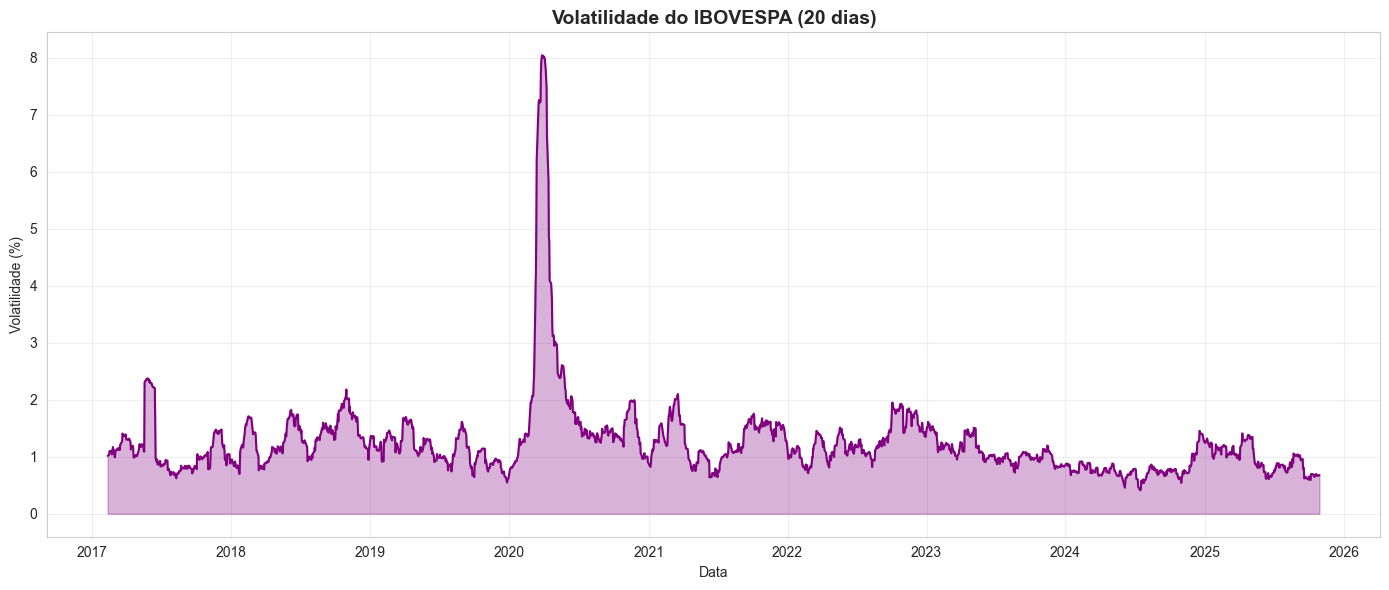

In [555]:
# Bloco 14 - Avaliação de volatilidade do IBOVESPA ao longo do tempo
# Criação de feature auxiliar para visualização (não é feature engineering do modelo ainda)
df['Vol_IBOV'] = df['Fechamento'].pct_change().rolling(20).std() * 100

plt.figure(figsize=(14, 6))
plt.plot(df['Data'], df['Vol_IBOV'], color='purple', linewidth=1.5)
plt.fill_between(df['Data'], df['Vol_IBOV'], alpha=0.3, color='purple')
plt.title('Volatilidade do IBOVESPA (20 dias)', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Volatilidade (%)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

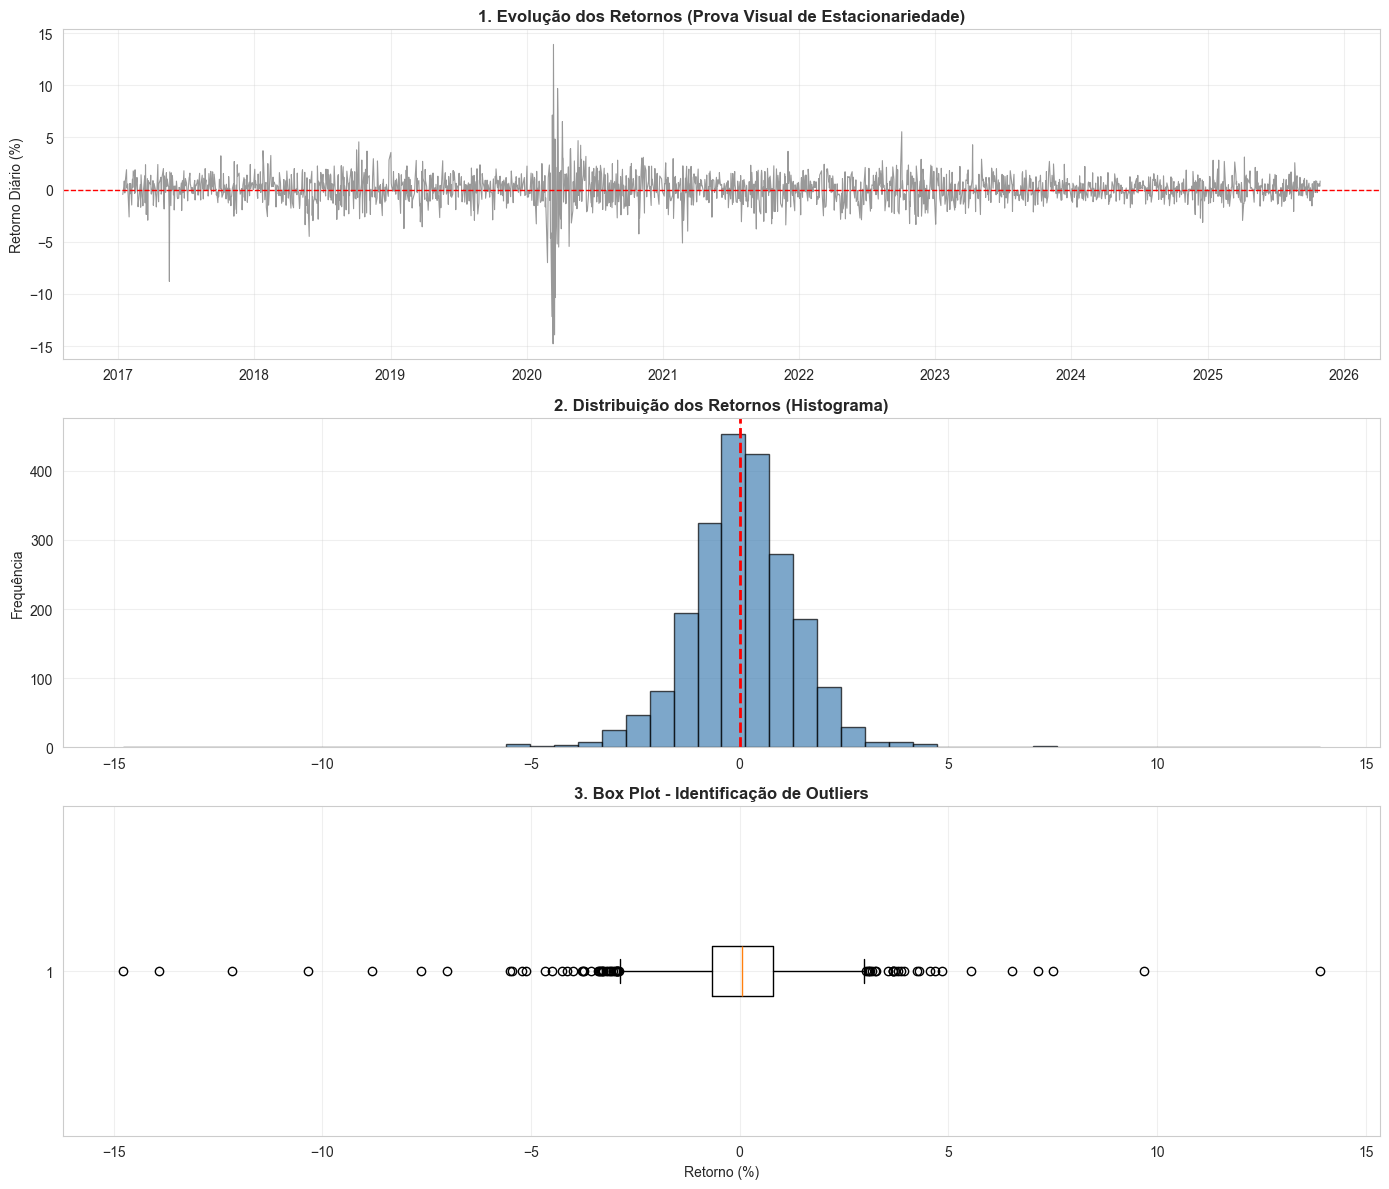

--------------------------------------------------
🔍 RESULTADO DO TESTE DE ESTACIONARIEDADE (ADF)
--------------------------------------------------
Estatística ADF: -15.2295
p-valor:         5.3459e-28

INTERPRETAÇÃO:
✅ SUCESSO: O p-valor é menor que 0.05.
   Conclusão: A série de Retornos é ESTACIONÁRIA.
   O modelo de Machine Learning funcionará corretamente.
--------------------------------------------------
Estatísticas Descritivas:
Média do Retorno: 0.049%
Volatilidade (Desvio): 1.451%


In [556]:
# BLOCO 15 - Avaliação de Estacionariedade e Normalidade dos Retornos
# Objetivo: Validar estatisticamente se os dados estão prontos para o modelo (Stationary Check).

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# 1. Criação da Feature de Retorno (Base para o teste)
df['Retorno'] = df['Fechamento'].pct_change() * 100
retornos_limpos = df['Retorno'].dropna()

# --- A. VISUALIZAÇÃO GRÁFICA (A PROVA VISUAL) ---
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1. Linha do Tempo (Visualização de Estacionariedade)
# Se os dados oscilam em torno do zero (linha vermelha) sem tendência de alta/baixa, é estacionário.
axes[0].plot(df['Data'], df['Retorno'], color='gray', alpha=0.8, linewidth=0.8)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('1. Evolução dos Retornos (Prova Visual de Estacionariedade)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Retorno Diário (%)')
axes[0].grid(alpha=0.3)

# 2. Histograma (Distribuição Normal?)
axes[1].hist(retornos_limpos, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('2. Distribuição dos Retornos (Histograma)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequência')
axes[1].grid(alpha=0.3)

# 3. Box Plot (Identificação de Outliers)
axes[2].boxplot(retornos_limpos, vert=False)
axes[2].set_title('3. Box Plot - Identificação de Outliers', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Retorno (%)')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- B. TESTE ESTATÍSTICO (O P-VALOR) ---
print("-" * 50)
print("🔍 RESULTADO DO TESTE DE ESTACIONARIEDADE (ADF)")
print("-" * 50)

try:
    result = adfuller(retornos_limpos)
    print(f"Estatística ADF: {result[0]:.4f}")
    print(f"p-valor:         {result[1]:.4e}")
    
    print("\nINTERPRETAÇÃO:")
    if result[1] <= 0.05:
        print("✅ SUCESSO: O p-valor é menor que 0.05.")
        print("   Conclusão: A série de Retornos é ESTACIONÁRIA.")
        print("   O modelo de Machine Learning funcionará corretamente.")
    else:
        print("⚠️ ALERTA: A série NÃO é estacionária (p > 0.05).")
        print("   O modelo pode ter dificuldades em generalizar.")
except Exception as e:
    print(f"Erro ao rodar o teste ADF. Verifique se a biblioteca 'statsmodels' está instalada. Erro: {e}")

print("-" * 50)
print(f"Estatísticas Descritivas:")
print(f"Média do Retorno: {retornos_limpos.mean():.3f}%")
print(f"Volatilidade (Desvio): {retornos_limpos.std():.3f}%")

### Feature Engineering

In [557]:
#Bloco 16 - Funções auxiliares de métricas financeiras
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(series, fast=12, slow=26):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    return ema_fast - ema_slow

def calculate_stochastic(df, period=14):
    low_min = df['Minima'].rolling(window=period).min()
    high_max = df['Maxima'].rolling(window=period).max()
    return 100 * (df['Fechamento'] - low_min) / (high_max - low_min)

def calculate_atr(df, period=14):
    high_low = df['Maxima'] - df['Minima']
    high_close = abs(df['Maxima'] - df['Fechamento'].shift())
    low_close = abs(df['Minima'] - df['Fechamento'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(window=period).mean()

def adicionar_features_tecnicas(df):
    # ... (cálculos de médias móveis, RSI, etc.) ...
    # ... (cálculos de Bandas de Bollinger, etc.) ...
    
    # ---------------------------------------------------------
    # ADICIONE ESTE BLOCO AQUI:
    # Remove as colunas originais de Máxima e Mínima para que elas 
    # NÃO virem features nem gerem vazamento.
    # ---------------------------------------------------------
    colunas_para_remover = ['Maxima', 'Minima']
    
    # # Verifica se elas existem antes de tentar remover para evitar erros
    cols_existentes = [c for c in colunas_para_remover if c in df.columns]
    if cols_existentes:
         df.drop(columns=cols_existentes, inplace=True)
    # ---------------------------------------------------------

    return df

In [558]:
# Bloco 17 - FEATURE ENGINEERING BLINDADO (SEM MÁXIMA/MÍNIMA)
# REGRA DE OURO: Tudo que usa Fechamento ou Volume deve ter .shift(1)
# REGRA DE PLATINA: Máxima (High) e Mínima (Low) foram BANIDAS (nem shiftadas podem usar).
# Exceção Única: Abertura (Open) do dia atual é permitida para cálculo de Gap.

def adicionar_features_tecnicas(df):
    # ---------------------------------------------------------
    # 1. LIMPEZA PREVENTIVA
    # Removemos Máxima e Mínima da memória para garantir que nenhuma
    # fórmula acesse esses dados proibidos.
    # ---------------------------------------------------------
    df.drop(columns=['Máxima', 'Minima', 'High', 'Low'], errors='ignore', inplace=True)

    # 2. Features de Preço Base (Ontem)
    df['Close_D1'] = df['Fechamento'].shift(1)
    df['Volume_D1'] = df['Volume'].shift(1)
    df['Open_Today'] = df['Abertura'] # Abertura de hoje permitida para Gap!

    # 3. Médias Móveis (Calculadas sobre Fechamento passados)
    df['MA_5'] = df['Fechamento'].rolling(window=5).mean().shift(1)
    df['MA_10'] = df['Fechamento'].rolling(window=10).mean().shift(1)
    df['MA_20'] = df['Fechamento'].rolling(window=20).mean().shift(1)
    df['MA_50'] = df['Fechamento'].rolling(window=50).mean().shift(1)

    # 4. Indicadores Técnicos (SOMENTE OS QUE USAM FECHAMENTO)
    # RSI e MACD usam apenas Fechamento, então são seguros.
    df['RSI'] = calculate_rsi(df['Fechamento'], 14).shift(1)
    df['MACD'] = calculate_macd(df['Fechamento']).shift(1)

    # ---------------------------------------------------------
    # 🚫 ZONA PROIBIDA (Removedores de High/Low)
    # Comentamos Stochastic e ATR pois suas fórmulas exigem High/Low
    # ---------------------------------------------------------
    # df['Stochastic'] = calculate_stochastic(df, 14).shift(1) 
    # df['ATR'] = calculate_atr(df, 14).shift(1)
    # ---------------------------------------------------------

    # 5. Volatilidade e Bollinger Bands (Baseado em Desvio Padrão do Fechamento - OK)
    df['Volatility_10'] = df['Fechamento'].rolling(window=10).std().shift(1)
    df['Volatility_20'] = df['Fechamento'].rolling(window=20).std().shift(1)

    # Bandas usam médias e volatilidade já calculadas (seguro)
    df['BB_upper'] = df['MA_20'] + (2 * df['Volatility_20'])
    df['BB_lower'] = df['MA_20'] - (2 * df['Volatility_20'])

    # Posição do preço em relação às bandas (normalizada)
    df['BB_position'] = (df['Close_D1'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])

    # 6. Retornos (Baseados em D-1)
    df['Return_1d'] = df['Fechamento'].pct_change(1).shift(1)
    df['Return_3d'] = df['Fechamento'].pct_change(3).shift(1)
    df['Return_5d'] = df['Fechamento'].pct_change(5).shift(1)

    # 7. Momentum e ROC (Baseados em D-1)
    df['Momentum_5'] = (df['Fechamento'] - df['Fechamento'].shift(5)).shift(1)
    df['ROC_5'] = (((df['Fechamento'] - df['Fechamento'].shift(5)) / df['Fechamento'].shift(5)) * 100).shift(1)

    # 8. Cruzamento de Médias (Sinais simples)
    df['MA_Cross_5_20'] = (df['MA_5'] > df['MA_20']).astype(int)
    df['MA_Cross_10_50'] = (df['MA_10'] > df['MA_50']).astype(int)

    # 9. Distância das Médias (Mean Reversion)
    df['Dist_MA5'] = ((df['Close_D1'] - df['MA_5']) / df['MA_5']) * 100
    df['Dist_MA20'] = ((df['Close_D1'] - df['MA_20']) / df['MA_20']) * 100

    # 10. Range e Gap 
    # ---------------------------------------------------------
    # 🚫 RANGE REMOVIDO (Usa High/Low)
    # df['Range_Pct'] = ((df['High_D1'] - df['Low_D1']) / df['Close_D1']) * 100
    # ---------------------------------------------------------
    
    # GAP MANTIDO (Usa Open de Hoje e Close de Ontem - Permitido!)
    df['Gap'] = ((df['Open_Today'] - df['Close_D1']) / df['Close_D1']) * 100

    # 11. Volume (Baseado em Ontem)
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean().shift(1)
    df['Volume_Ratio'] = df['Volume_D1'] / df['Volume_MA5']

    # 12. Temporal
    df['DayOfWeek'] = df['Data'].dt.dayofweek
    df['Month'] = df['Data'].dt.month
    df['Year'] = df['Data'].dt.year
    df['Quarter'] = df['Data'].dt.quarter

    # Removemos linhas iniciais que ficaram com NaN devido ao shift
    df = df.dropna().reset_index(drop=True)
    
    return df

# --- APLICAÇÃO DA FUNÇÃO (ISTO QUE ESTAVA FALTANDO) ---
# Aqui nós efetivamente transformamos o DataFrame
df = adicionar_features_tecnicas(df)

# Agora sim verificamos
print("✓ Features Blindadas criadas com sucesso.")
print(f"✓ Linhas restantes: {len(df)}")
print("✓ Colunas atuais:", df.columns.tolist())
df.head()

print("✓ Features IBOVESPA recriadas. Features proibidas (High/Low/Stoch/ATR) foram removidas.")

✓ Features Blindadas criadas com sucesso.
✓ Linhas restantes: 2135
✓ Colunas atuais: ['Data', 'Último', 'Abertura', 'Maxima', 'Volume', 'Fechamento', 'Vol_IBOV', 'Retorno', 'Close_D1', 'Volume_D1', 'Open_Today', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'RSI', 'MACD', 'Volatility_10', 'Volatility_20', 'BB_upper', 'BB_lower', 'BB_position', 'Return_1d', 'Return_3d', 'Return_5d', 'Momentum_5', 'ROC_5', 'MA_Cross_5_20', 'MA_Cross_10_50', 'Dist_MA5', 'Dist_MA20', 'Gap', 'Volume_MA5', 'Volume_Ratio', 'DayOfWeek', 'Month', 'Year', 'Quarter']
✓ Features IBOVESPA recriadas. Features proibidas (High/Low/Stoch/ATR) foram removidas.


In [559]:
# Bloco 18 - Visualizando df
df.head()

Price,Data,Último,Abertura,Maxima,Volume,Fechamento,Vol_IBOV,Retorno,Close_D1,Volume_D1,Open_Today,MA_5,MA_10,MA_20,MA_50,RSI,MACD,Volatility_10,Volatility_20,BB_upper,BB_lower,BB_position,Return_1d,Return_3d,Return_5d,Momentum_5,ROC_5,MA_Cross_5_20,MA_Cross_10_50,Dist_MA5,Dist_MA20,Gap,Volume_MA5,Volume_Ratio,DayOfWeek,Month,Year,Quarter
0,2017-03-28,64640.0,64308.0,64847.0,3359100.0,64640.0,1.359561,0.516265,64308.0,2672800.0,64308.0,63638.8,64400.5,65094.60,65448.64,43.111068,-584.081965,1026.885826,1181.792368,67458.184735,62731.015265,0.333600,0.007110,0.012390,-0.008877,-576.0,-0.887738,0,0,1.051560,-1.208395,0.000000,3290980.0,0.812159,1,3,2017,1
1,2017-03-29,65528.0,64636.0,65551.0,3488200.0,65528.0,1.395172,1.373762,64640.0,3359100.0,64636.0,63970.8,64394.6,64993.50,65462.36,49.598600,-527.028179,1025.148249,1125.810235,67245.120469,62741.879531,0.421501,0.005163,0.017456,0.026358,1660.0,2.635757,0,0,1.046102,-0.543901,-0.006188,3222760.0,1.042305,2,3,2017,1
2,2017-03-30,65266.0,65541.0,65775.0,2335700.0,65266.0,1.346637,-0.399829,65528.0,3488200.0,65541.0,64372.2,64323.9,64920.45,65499.88,54.502913,-405.484294,900.980879,1033.096239,66986.642478,62854.257522,0.647022,0.013738,0.026216,0.031596,2007.0,3.159585,0,0,1.795496,0.935838,0.019839,3107740.0,1.122423,3,3,2017,1
3,2017-03-31,64984.0,65266.0,65597.0,2614200.0,64984.0,1.304629,-0.432078,65266.0,2335700.0,65266.0,64719.2,64272.2,64891.00,65528.58,52.776473,-326.536984,819.061088,1013.258007,66917.516015,62864.483985,0.592523,-0.003998,0.014897,0.027310,1735.0,2.730950,0,0,0.844881,0.577892,0.000000,2885400.0,0.809489,4,3,2017,1
4,2017-04-03,65211.0,64989.0,65384.0,2858500.0,65211.0,1.302360,0.349317,64984.0,2614200.0,64989.0,64945.2,64349.6,64800.90,65541.18,47.268031,-283.458187,848.569541,910.824028,66622.548057,62979.251943,0.550257,-0.004321,0.005322,0.017697,1130.0,1.769662,1,0,0.059743,0.282558,0.007694,2894000.0,0.903317,0,4,2017,2


In [560]:
# Bloco 19 - FEATURE ENGINEERING EXTERNO (DESATIVADO TEMPORARIAMENTE)
# Este bloco depende dos dados macroeconômicos (Blocos 6-8) que estão desligados.
# A lógica abaixo JÁ ESTÁ CORRIGIDA com .shift(1) para quando formos reativar.

# print("⚠️ Criação de features externas pulada (Foco no Baseline).")

# # Variações dos Dados Externos (SHIFT(1) É OBRIGATÓRIO)
# # df['Dolar_Var'] = df['Dolar'].pct_change().shift(1) * 100
# # df['SP500_Var'] = df['SP500'].pct_change().shift(1) * 100
# # df['VIX_Var'] = df['VIX'].pct_change().shift(1) * 100
# # df['Petroleo_Var'] = df['Petroleo'].pct_change().shift(1) * 100

# # df['Dolar_Var5d'] = df['Dolar'].pct_change(5).shift(1) * 100
# # df['SP500_Var5d'] = df['SP500'].pct_change(5).shift(1) * 100

# # Correlações móveis (Baseadas em D-1)
# # df['Corr_SP500_20d'] = df['Fechamento'].shift(1).rolling(20).corr(df['SP500'].shift(1))
# # df['Corr_Dolar_20d'] = df['Fechamento'].shift(1).rolling(20).corr(df['Dolar'].shift(1))

# # Features Lagged dos Dados Externos
# # for i in [1, 2, 3]:
# #     df[f'Dolar_lag{i}'] = df['Dolar'].shift(i)
# #     df[f'SP500_lag{i}'] = df['SP500'].shift(i)
# #     df[f'VIX_lag{i}'] = df['VIX'].shift(i)
# #     df[f'Petroleo_lag{i}'] = df['Petroleo'].shift(i)
# #     df[f'SP500_Var_lag{i}'] = df['SP500_Var'].shift(i)  # Já é shiftado, mas ok reforçar lag
# #     df[f'Dolar_Var_lag{i}'] = df['Dolar_Var'].shift(i)

# # Médias Móveis dos Dados Externos (Calculadas sobre D-1)
# # df['SP500_MA5'] = df['SP500'].rolling(5).mean().shift(1)
# # df['SP500_MA20'] = df['SP500'].rolling(20).mean().shift(1)
# # df['Dolar_MA5'] = df['Dolar'].rolling(5).mean().shift(1)
# # df['Dolar_MA20'] = df['Dolar'].rolling(20).mean().shift(1)

# # Distância das Médias (Preço D-1 vs Média D-1)
# # df['SP500_Dist_MA5'] = ((df['SP500'].shift(1) - df['SP500_MA5']) / df['SP500_MA5']) * 100
# # df['Dolar_Dist_MA5'] = ((df['Dolar'].shift(1) - df['Dolar_MA5']) / df['Dolar_MA5']) * 100

# # Razões entre ativos (Usando dados de D-1)
# # df['Razao_IBOV_SP500'] = df['Fechamento'].shift(1) / df['SP500'].shift(1)
# # df['Razao_IBOV_Dolar'] = df['Fechamento'].shift(1) / df['Dolar'].shift(1)

# # Volatilidade dos Dados Externos (Shift 1)
# # df['SP500_Vol10d'] = df['SP500'].rolling(10).std().shift(1)
# # df['Dolar_Vol10d'] = df['Dolar'].rolling(10).std().shift(1)

# # Sinalizadores de Tendência
# # df['SP500_Tendencia'] = (df['SP500_MA5'] > df['SP500_MA20']).astype(int)
# # df['Dolar_Tendencia'] = (df['Dolar_MA5'] > df['Dolar_MA20']).astype(int)
# # df['VIX_Alto'] = (df['VIX'].shift(1) > 20).astype(int)
# # df['VIX_Baixo'] = (df['VIX'].shift(1) < 15).astype(int)

# # print("  ✓ Features dados externos criadas (Desativadas)")

In [561]:
# Bloco 20 - LIMPEZA DE DADOS (CORRIGIDO)
# Remover NaNs gerados pelos shifts e cálculos de indicadores.
# NÃO usamos 'bfill' para evitar olhar dados do futuro nas primeiras linhas.

print("\n🔧 Limpando dados...")

antes = len(df)

# Substituir infinitos por NaN (gerados por divisões por zero, ex: pct_change em dias parados)
df = df.replace([np.inf, -np.inf], np.nan)

# Preencher NaNs apenas com Forward Fill (dados passados) se houver buracos no meio
# Mas para o início da série (gerado pelos shifts), o correto é dropar.
df = df.fillna(method='ffill')

# Remover linhas com NaN restantes (crucial para eliminar o início "vazio" da série)
df = df.dropna()

depois = len(df)

print(f"✓ Dataset limpo: {depois} linhas")
print(f"✓ Linhas removidas (janela de aquecimento dos indicadores): {antes - depois}")


🔧 Limpando dados...
✓ Dataset limpo: 2135 linhas
✓ Linhas removidas (janela de aquecimento dos indicadores): 0


### Preparação dos Dados

In [562]:
df.dtypes

Price
Data              datetime64[ns]
Último                   float64
Abertura                 float64
Maxima                   float64
Volume                   float64
Fechamento               float64
Vol_IBOV                 float64
Retorno                  float64
Close_D1                 float64
Volume_D1                float64
Open_Today               float64
MA_5                     float64
MA_10                    float64
MA_20                    float64
MA_50                    float64
RSI                      float64
MACD                     float64
Volatility_10            float64
Volatility_20            float64
BB_upper                 float64
BB_lower                 float64
BB_position              float64
Return_1d                float64
Return_3d                float64
Return_5d                float64
Momentum_5               float64
ROC_5                    float64
MA_Cross_5_20              int64
MA_Cross_10_50             int64
Dist_MA5                 float64
Dist

✓ Features limpas: 31
✓ Colunas removidas: ['Target', 'Fechamento', 'Abertura', 'Maxima', 'Minima', 'Volume', 'Último', 'Vol.', 'Maxima', 'Minima', 'Volume', 'Retorno', 'Vol_IBOV', 'Fechamento_Ajustado']


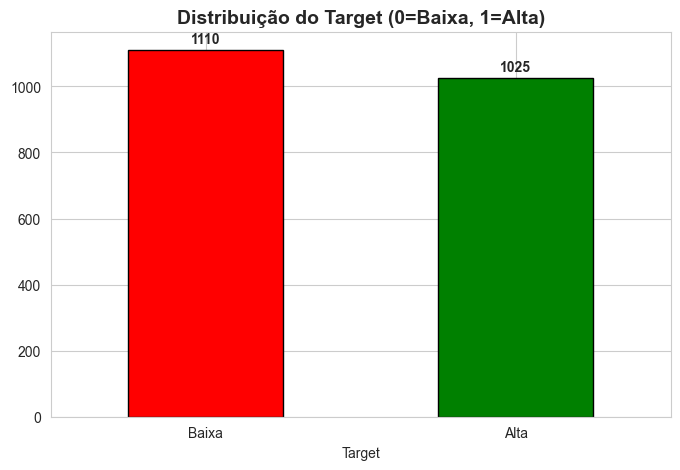

In [563]:
# Bloco 21 - DEFINIÇÃO DE TARGET CORRETA (D-1 prevê D0) e LIMPEZA DE LEAKAGE
# Correção: Adicionamos 'Retorno' e 'Vol_IBOV' na lista de remoção.

# Lógica: O Fechamento de HOJE foi maior que o de ONTEM?
df['Target'] = (df['Fechamento'] > df['Fechamento'].shift(1)).astype(int)

# Removemos linhas com NaN gerados pelo shift
df = df.dropna()

# Definição das features (X) e dependente (y)
# REMOVENDO TODAS AS COLUNAS QUE CONTÊM DADOS DO FUTURO/PRESENTE
cols_proibidas = [
    'Target', 
    'Fechamento', 'Abertura', 'Maxima', 'Minima', 'Volume', # Nomes Padrão
    'Último', 'Vol.',                                       # Nomes Yahoo 
    'Maxima', 'Minima', 'Volume', 'Retorno', 'Vol_IBOV',    # Nomes Legados
    'Fechamento_Ajustado'
]

# Drop seguro (ignora erros se a coluna não existir)
X = df.drop(cols_proibidas, axis=1, errors='ignore')
y = df['Target']

datas = df['Data']

print(f"✓ Features limpas: {len(X.columns)}")
print(f"✓ Colunas removidas: {cols_proibidas}")

# Visualização da distribuição
plt.figure(figsize=(8, 5))
df['Target'].value_counts().plot(kind='bar', color=['red', 'green'], edgecolor='black')
plt.title('Distribuição do Target (0=Baixa, 1=Alta)', fontsize=14, fontweight='bold')
plt.xticks([0, 1], ['Baixa', 'Alta'], rotation=0)
for i, v in enumerate(df['Target'].value_counts()):
    plt.text(i, v + 20, str(v), ha='center', fontweight='bold')
plt.show()

In [564]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2135 entries, 0 to 2134
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Data            2135 non-null   datetime64[ns]
 1   Último          2135 non-null   float64       
 2   Abertura        2135 non-null   float64       
 3   Maxima          2135 non-null   float64       
 4   Volume          2135 non-null   float64       
 5   Fechamento      2135 non-null   float64       
 6   Vol_IBOV        2135 non-null   float64       
 7   Retorno         2135 non-null   float64       
 8   Close_D1        2135 non-null   float64       
 9   Volume_D1       2135 non-null   float64       
 10  Open_Today      2135 non-null   float64       
 11  MA_5            2135 non-null   float64       
 12  MA_10           2135 non-null   float64       
 13  MA_20           2135 non-null   float64       
 14  MA_50           2135 non-null   float64       
 15  RSI 

In [565]:
# CÓDIGO DE INVESTIGAÇÃO
print("🕵️‍♂️ Caçando colunas de Data no DataFrame:")
for col in df.columns:
    if df[col].dtype == 'datetime64[ns]':
        print(f"   ⚠️ ENCONTRADA: {col}")

🕵️‍♂️ Caçando colunas de Data no DataFrame:
   ⚠️ ENCONTRADA: Data


In [566]:
# BLOCO 22 e 23 - DIVISÃO TREINO/TESTE (HÍBRIDO: MANUAL ou REALISTA)
# Objetivo: Permitir alternar entre teste focado (janela específica) e teste realista (futuro).

from sklearn.preprocessing import StandardScaler

# ==============================================================================
# ⚙️ CONFIGURAÇÃO DA DIVISÃO (MEXA AQUI)
# Opções: 'REALISTA' (Treina no passado, testa no futuro) ou 'MANUAL' (Sua janela específica)
MODO_TESTE = 'MANUAL' 

# CONFIGURAÇÃO A (Se MODO_TESTE = 'REALISTA')
DATA_CORTE_REALISTA = '2025-09-30'

# CONFIGURAÇÃO B (Se MODO_TESTE = 'MANUAL')
DATA_INICIO_MANUAL = '2024-10-01'
DATA_FIM_MANUAL    = '2025-10-01'
# ==============================================================================

print(f"⏳ Configurando Divisão: Modo {MODO_TESTE}...")

# 1. Definição das Features (BLINDAGEM)
# Mantemos a proteção contra vazamento independente do modo.
cols_proibidas = [
    'Data', 'Target', 
    'Fechamento', 'Abertura', 'Maxima', 'Minima', 'Volume',
    'Retorno', 'Vol_IBOV','Último' # Features do futuro/hoje removidas
]
features = [col for col in df.columns if col not in cols_proibidas]

# 2. Lógica de Seleção das Máscaras
if MODO_TESTE == 'REALISTA':
    # Lógica Cronológica Padrão
    mask_train = (df['Data'] < DATA_CORTE_REALISTA)
    mask_test = (df['Data'] >= DATA_CORTE_REALISTA)
    print(f"   Corte Temporal: {DATA_CORTE_REALISTA}")

elif MODO_TESTE == 'MANUAL':
    # Lógica da Janela Específica (O resto vira treino)
    mask_test = (df['Data'] >= DATA_INICIO_MANUAL) & (df['Data'] <= DATA_FIM_MANUAL)
    mask_train = ~mask_test # Todo o resto é treino
    print(f"   Janela Manual: {DATA_INICIO_MANUAL} até {DATA_FIM_MANUAL}")

# 3. Aplicação do Split
X_train_raw = df.loc[mask_train, features]
y_train = df.loc[mask_train, 'Target']

X_test_raw = df.loc[mask_test, features]
y_test = df.loc[mask_test, 'Target']

# Guardamos datas e preços para gráficos
datas_test = df.loc[mask_test, 'Data']
precos_test = df.loc[mask_test, 'Fechamento'] 

# 4. Normalização (Escalonamento)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# 5. Validação
print("\n📊 Resumo da Divisão:")
print(f"   Treino: {len(y_train)} dias")
print(f"   Teste:  {len(y_test)} dias ({df.loc[mask_test, 'Data'].min().date()} a {df.loc[mask_test, 'Data'].max().date()})")

if len(y_test) < 10:
    print("⚠️ ALERTA CRÍTICO: Janela de teste muito pequena ou vazia! Verifique as datas.")
else:
    print("✅ Divisão Concluída.")

⏳ Configurando Divisão: Modo MANUAL...
   Janela Manual: 2024-10-01 até 2025-10-01

📊 Resumo da Divisão:
   Treino: 1885 dias
   Teste:  250 dias (2024-10-01 a 2025-10-01)
✅ Divisão Concluída.


In [567]:
# # Bloco 22 - Definindo as datas de corte
# DATA_INICIO_TESTE = '2020-04-01'
# DATA_FIM_TESTE = '2020-05-05'

# # --- 1. Definindo o Conjunto de Teste ---
# # Aqui usamos .loc no DataFrame ORIGINAL (df) para fatiar as datas.
# # Em seguida, usamos o INDEX dessas datas para buscar as linhas corretas em X e y.

# # Máscara para selecionar o período de teste nas datas originais
# mascara_teste = (df['Data'] >= DATA_INICIO_TESTE) & (df['Data'] <= DATA_FIM_TESTE)

# # Aplicando a máscara nos DataFrames X e y
# X_test = X.loc[mascara_teste]
# y_test = y.loc[mascara_teste]
# datas_test = datas.loc[mascara_teste]

# # --- 2. Definindo o Conjunto de Treino ---
# # O treino será todo o restante dos dados (o oposto da máscara de teste)
# mascara_treino = ~mascara_teste

# X_train = X.loc[mascara_treino]
# y_train = y.loc[mascara_treino]
# datas_train = datas.loc[mascara_treino]

# print(f"Treino: {len(X_train)} amostras (de {datas_train.min().date()} à {datas_train.max().date()})")
# print(f"Teste: {len(X_test)} amostras (de {datas_test.min().date()} à {datas_test.max().date()})")

In [568]:
# # Bloco 23 - Normalização dos dados com StandardScaler (z-Score) para que todas as features estejam na mesma escala

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

### Seleção da Features com RFECV (Recursive feature elimination with cross-validation)

In [569]:
# Bloco 24 - SELEÇÃO DE FEATURES (DESATIVADA / PASS-THROUGH)
# O tutor recomendou NÃO usar RFE neste momento para validar o baseline com todas as features.

print("\n⚠️ RFECV desativado conforme recomendação do tutor.")
print("   Utilizando TODAS as features criadas e corrigidas (Shift 1).")

# Bypass: As "features selecionadas" são TODAS as features
selected_features = X.columns.tolist()

# Mantendo a nomenclatura das variáveis para compatibilidade com os próximos blocos
# Apenas copiamos os dados já normalizados no Bloco 22
X_train_scaled_sel = X_train_scaled
X_test_scaled_sel = X_test_scaled

print(f"\n✓ Features mantidas para o modelo: {len(selected_features)}")
# print(f"✓ Melhor CV score: N/A") # RFE desligado


⚠️ RFECV desativado conforme recomendação do tutor.
   Utilizando TODAS as features criadas e corrigidas (Shift 1).

✓ Features mantidas para o modelo: 31


### Cross Validation

In [570]:
# Bloco 25 - Definição dos modelos com hiperparâmetros otimizados
modelos_cv = {
    'Logistic Regression': LogisticRegression(
        C=0.01,
        max_iter=1000,
        random_state=42
    ),

    'Random Forest': RandomForestClassifier(
        n_estimators=50,
        max_depth=4,
        min_samples_split=50,
        min_samples_leaf=20,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),

    'XGBoost': XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.01,
        subsample=0.7,
        colsample_bytree=0.5,
        reg_alpha=1.0,
        reg_lambda=2.0,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
}

In [571]:
# Bloco 26 - Verificação e Limpeza de NaNs (BLINDADO)
# Função: Garante que X_train e X_test não tenham buracos (NaN) ou Infinitos.
# Correção: Recupera automaticamente os nomes das colunas se houver divergência.

import pandas as pd
import numpy as np

print("\n🔍 Verificando integridade dos dados (NaNs e Infinitos)...")

# --- 1. TENTATIVA DE RECUPERAÇÃO DE NOMES ---
# O erro acontecia porque 'selected_features' tinha 31 nomes e os dados tinham 32 colunas.
# Vamos tentar usar a lista 'features' original do Bloco 22/23 se ela tiver o tamanho certo.

cols_para_check = []
if 'selected_features' in locals() and len(selected_features) == X_train_scaled_sel.shape[1]:
    cols_para_check = selected_features
    print("✓ Usando nomes de 'selected_features'.")
elif 'features' in locals() and len(features) == X_train_scaled_sel.shape[1]:
    cols_para_check = features
    print("✓ Divergência encontrada em 'selected_features', recuperando nomes de 'features' originais.")
    # Atualiza a variável global para os próximos blocos não quebrarem
    selected_features = features 
else:
    print(f"⚠️ AVISO: Não foi possível alinhar nomes ({len(selected_features)} nomes vs {X_train_scaled_sel.shape[1]} colunas).")
    print("   -> Usando índices numéricos temporários.")
    cols_para_check = range(X_train_scaled_sel.shape[1])

# --- 2. CONVERSÃO E CHECK ---
try:
    X_train_check = pd.DataFrame(X_train_scaled_sel, columns=cols_para_check)
except Exception as e:
    # Último recurso: DataFrame sem nomes
    X_train_check = pd.DataFrame(X_train_scaled_sel)

# --- 3. VERIFICAÇÃO E LIMPEZA DE NANS ---
total_nans = X_train_check.isnull().sum().sum()
print(f"Total de NaNs encontrados: {total_nans}")

if total_nans > 0:
    print("\n⚠️ Colunas com NaN detectadas (Amostra):")
    print(X_train_check.isnull().sum()[X_train_check.isnull().sum() > 0])

    print("\n🔧 Limpando linhas com NaNs...")
    # Máscara de linhas válidas (sem nenhum NaN)
    mask_validos = ~np.isnan(X_train_scaled_sel).any(axis=1)
    
    # Aplica o filtro
    antes = len(X_train_scaled_sel)
    X_train_scaled_sel = X_train_scaled_sel[mask_validos]
    y_train = y_train[mask_validos] # Alinha o Target
    
    print(f"✓ Limpeza concluída: {antes - len(X_train_scaled_sel)} linhas removidas.")
else:
    print("✓ Nenhum NaN encontrado.")

# --- 4. VERIFICAÇÃO DE INFINITOS ---
inf_count = np.isinf(X_train_scaled_sel).sum()
if inf_count > 0:
    print(f"\n⚠️ {inf_count} valores infinitos encontrados. Substituindo por 0...")
    X_train_scaled_sel = np.nan_to_num(X_train_scaled_sel, nan=0.0, posinf=0.0, neginf=0.0)
    if 'X_test_scaled_sel' in locals():
        X_test_scaled_sel = np.nan_to_num(X_test_scaled_sel, nan=0.0, posinf=0.0, neginf=0.0)
    print("✓ Infinitos corrigidos!")

print(f"\n✅ Dados Limpos e Prontos! Shape Final: {X_train_scaled_sel.shape}")


🔍 Verificando integridade dos dados (NaNs e Infinitos)...
✓ Divergência encontrada em 'selected_features', recuperando nomes de 'features' originais.
Total de NaNs encontrados: 0
✓ Nenhum NaN encontrado.

✅ Dados Limpos e Prontos! Shape Final: (1885, 30)


In [572]:
# Bloco 26.1 - TREINAMENTO E VALIDAÇÃO CRUZADA (CROSS-VALIDATION)
# Objetivo: Testar vários modelos nos dados limpos e cronológicos.

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

print("🚀 Iniciando Treinamento com TimeSeriesSplit...")

# Modelos para testar
modelos = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42, eval_metric='logloss'),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

# Configuração da Validação Cruzada Temporal (Respeita o tempo)
# 5 divisões: Treina em Jan/Fev -> Testa Março; Treina Jan/Fev/Mar -> Testa Abril...
tscv = TimeSeriesSplit(n_splits=5)

resultados = {}

for nome, modelo in modelos.items():
    # cv_scores = cross_val_score(modelo, X_train_scaled_sel, y_train, cv=tscv, scoring='accuracy')
    # print(f"{nome}: Média {cv_scores.mean():.2%} (+/- {cv_scores.std():.2%})")
    
    # Treina no conjunto total de treino para avaliação final
    modelo.fit(X_train_scaled_sel, y_train)
    acc_train = modelo.score(X_train_scaled_sel, y_train)
    
    # Se X_test_scaled_sel não existir (caso não tenha seleção), usa o original
    X_teste_final = X_test_scaled_sel if 'X_test_scaled_sel' in locals() else X_test_scaled
    acc_test = modelo.score(X_teste_final, y_test)
    
    resultados[nome] = {'Modelo': modelo, 'Train': acc_train, 'Test': acc_test}
    print(f"   ✓ {nome:20s} | Treino: {acc_train:.1%} | Teste (Futuro): {acc_test:.1%}")

# Seleção do Melhor Modelo (baseado no Teste)
melhor_nome = max(resultados, key=lambda k: resultados[k]['Test'])
melhor_modelo = resultados[melhor_nome]['Modelo']
melhor_acc = resultados[melhor_nome]['Test'] * 100

print(f"\n🏆 MELHOR MODELO: {melhor_nome} com {melhor_acc:.2f}% de acurácia no teste.")

# Salva features finais para os gráficos
features_finais = selected_features if 'selected_features' in locals() else features

🚀 Iniciando Treinamento com TimeSeriesSplit...
   ✓ Logistic Regression  | Treino: 56.1% | Teste (Futuro): 53.2%
   ✓ Random Forest        | Treino: 72.5% | Teste (Futuro): 55.6%
   ✓ XGBoost              | Treino: 70.1% | Teste (Futuro): 60.8%
   ✓ SVM                  | Treino: 63.2% | Teste (Futuro): 52.4%

🏆 MELHOR MODELO: XGBoost com 60.80% de acurácia no teste.


In [573]:
# # Bloco 26 - Verificação e limpeza de NaNs e infinitos nos dados escalados
# # Verificar NaNs no X_train_scaled_sel
# # É um bloco de "segurança" muito importante.
# # Como fizemos muitos cálculos matemáticos (divisões, variações percentuais), podem ter surgido valores infinitos (inf) ou nulos (NaN) residuais.
# # Este código garante que o modelo não quebre na próxima etapa.

# print("\n🔍 Verificando NaNs nos dados escalados...")

# # Converter para DataFrame temporariamente para verificar
# X_train_check = pd.DataFrame(X_train_scaled_sel, columns=selected_features)

# total_nans = X_train_check.isnull().sum().sum()
# print(f"Total de NaNs: {total_nans}")

# if total_nans > 0:
#     print("\nColunas com NaN:")
#     for col in X_train_check.columns:
#         nans = X_train_check[col].isnull().sum()
#         if nans > 0:
#             print(f"  {col}: {nans} NaNs")

#     # Limpar
#     print("\n🔧 Limpando NaNs...")
#     mask = ~X_train_check.isnull().any(axis=1)
#     X_train_scaled_sel = X_train_scaled_sel[mask]
#     y_train = y_train[mask.values]

#     print(f"✓ Dados limpos: {len(X_train_scaled_sel)} amostras restantes")
# else:
#     print("✓ Nenhum NaN encontrado!")

# # Verificar infinitos
# inf_count = np.isinf(X_train_scaled_sel).sum()
# if inf_count > 0:
#     print(f"\n⚠️ {inf_count} valores infinitos encontrados. Corrigindo...")
#     X_train_scaled_sel = np.nan_to_num(X_train_scaled_sel, nan=0, posinf=0, neginf=0)
#     X_test_scaled_sel = np.nan_to_num(X_test_scaled_sel, nan=0, posinf=0, neginf=0)
#     print("✓ Infinitos corrigidos!")

# print("\n✅ Dados prontos para Cross-Validation!\n")

In [574]:
# Bloco 27 - AVALIAÇÃO DETALHADA (BASELINE COM CROSS-VALIDATION)
# Objetivo: Validar a estabilidade dos modelos (CV) e verificar overfitting.

# Configuração da Validação Cruzada (Respeita a ordem temporal)
tscv = TimeSeriesSplit(n_splits=5)

# Reinicializa resultados para garantir dados frescos
resultados = {}

# Define qual X de teste usar (Segurança: usa o selecionado se existir, senão usa o total)
X_teste_final = X_test_scaled_sel if 'X_test_scaled_sel' in locals() else X_test_scaled

print("🚀 Iniciando Cross-Validation Detalhado...")

# Usa o dicionário 'modelos' definido no Bloco 26.1
for nome, modelo in modelos.items(): 
    print(f"\n📊 {nome}...")

    # 1. Validação Cruzada (CV) - Avalia a estabilidade no TREINO
    # Nota: O CV divide o treino em pedaços temporais
    cv_scores = cross_val_score(
        modelo,
        X_train_scaled_sel, # Usa o X de treino selecionado
        y_train,
        cv=tscv,
        scoring='accuracy',
        n_jobs=-1
    )

    print(f"   CV Scores: {[f'{s:.3f}' for s in cv_scores]}")
    print(f"   Média CV: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

    # 2. Treinamento Final (Fit) no Treino Completo
    modelo.fit(X_train_scaled_sel, y_train)

    # 3. Avaliação Final
    acc_train = modelo.score(X_train_scaled_sel, y_train)
    acc_test = modelo.score(X_teste_final, y_test)

    # 4. Salvar resultados no padrão para os gráficos
    resultados[nome] = {
        'Modelo': modelo,        # Guardamos o objeto treinado
        'cv_mean': cv_scores.mean(),
        'acc_train': acc_train,
        'acc_test': acc_test
    }

    # Verificar Overfitting (Diferença entre Treino e Teste)
    diff = acc_train - acc_test
    status = "✓ Estável" if diff < 0.15 else "⚠️ Overfitting"

    print(f"   Treino: {acc_train*100:.2f}% | Teste: {acc_test*100:.2f}% | Diff: {diff*100:.1f}% {status}")

# Atualiza as variáveis do Melhor Modelo com base nessa rodada mais detalhada
melhor_nome = max(resultados, key=lambda k: resultados[k]['acc_test'])
melhor_modelo = resultados[melhor_nome]['Modelo']
melhor_acc = resultados[melhor_nome]['acc_test'] * 100

print("-" * 50)
print(f"🏆 MELHOR MODELO CONFIRMADO: {melhor_nome} ({melhor_acc:.2f}%)")

🚀 Iniciando Cross-Validation Detalhado...

📊 Logistic Regression...
   CV Scores: ['0.522', '0.510', '0.535', '0.525', '0.494']
   Média CV: 0.517 (±0.014)
   Treino: 56.13% | Teste: 53.20% | Diff: 2.9% ✓ Estável

📊 Random Forest...
   CV Scores: ['0.487', '0.529', '0.586', '0.634', '0.608']
   Média CV: 0.569 (±0.054)
   Treino: 72.52% | Teste: 55.60% | Diff: 16.9% ⚠️ Overfitting

📊 XGBoost...
   CV Scores: ['0.494', '0.522', '0.583', '0.637', '0.643']
   Média CV: 0.576 (±0.060)
   Treino: 70.08% | Teste: 60.80% | Diff: 9.3% ✓ Estável

📊 SVM...
   CV Scores: ['0.519', '0.548', '0.510', '0.545', '0.510']
   Média CV: 0.526 (±0.017)
   Treino: 63.18% | Teste: 52.40% | Diff: 10.8% ✓ Estável
--------------------------------------------------
🏆 MELHOR MODELO CONFIRMADO: XGBoost (60.80%)


In [575]:
# Bloco 28 - AUDITORIA DE VAZAMENTO DE DADOS ---
print(" Auditoria de features (Correlação com Target)...")

# Calcula a correlação de todas as features com o Target
correlations = X_train_scaled_sel.copy() if isinstance(X_train_scaled_sel, pd.DataFrame) else pd.DataFrame(X_train_scaled_sel, columns=selected_features)
correlations['TARGET_TEMP'] = y_train.values
corr_matrix = correlations.corr()['TARGET_TEMP'].abs().sort_values(ascending=False)

print("\n🚨 TOP 10 Features mais suspeitas (Correlação próxima de 1.0 = Vazamento):")
print(corr_matrix.head(10))

# Se houver alguma correlação > 0.90 (exceto o próprio Target), temos um vazamento.
if corr_matrix.iloc[1] > 0.90:
    print(f"\n⚠️ ALERTA VERMELHO: A feature '{corr_matrix.index[1]}' está vazando a resposta!")
else:
    print("\n✅ Nenhuma feature óbvia encontrada (Features OK).")

 Auditoria de features (Correlação com Target)...

🚨 TOP 10 Features mais suspeitas (Correlação próxima de 1.0 = Vazamento):
TARGET_TEMP    1.000000
Gap            0.085967
BB_lower       0.041571
MA_20          0.040216
MA_50          0.038590
Return_1d      0.037950
BB_upper       0.037885
MA_10          0.037137
Close_D1       0.037088
Open_Today     0.036581
Name: TARGET_TEMP, dtype: float64

✅ Nenhuma feature óbvia encontrada (Features OK).


### Otimização GRID SEARCH

In [576]:
# Bloco 29 - OTIMIZAÇÃO DE HIPERPARÂMETROS (XGBOOST)
# Foco total no XGBoost conforme pedido do professor.

# Parâmetros específicos para tunar o XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],         # Quantidade de árvores
    'max_depth': [3, 5, 7],                 # Profundidade máxima (evita overfitting)
    'learning_rate': [0.01, 0.05, 0.1],     # Taxa de aprendizado
    'subsample': [0.8, 1.0],                # Amostragem de linhas
    'colsample_bytree': [0.8, 1.0]          # Amostragem de colunas
}

# Instancia o modelo base
xgb_grid = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

print("\n🔍 Otimizando XGBoost (Isso pode demorar um pouco)...")

# Configura o Grid Search
grid_search = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid_xgb,
    cv=tscv,              # Usa a validação temporal definida antes
    scoring='accuracy',
    n_jobs=-1,
    verbose=1             # Verbose 1 mostra o progresso
)

# Treina
grid_search.fit(X_train_scaled_sel, y_train)

# Resultados
print(f"\n✓ Melhores parâmetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

best_model = grid_search.best_estimator_
acc_train_best = best_model.score(X_train_scaled_sel, y_train)
acc_test_best = best_model.score(X_test_scaled_sel, y_test)

print(f"\n📊 XGBoost Otimizado:")
print(f"  CV Score (Média): {grid_search.best_score_:.4f}")
print(f"  Treino: {acc_train_best*100:.2f}%")
print(f"  Teste: {acc_test_best*100:.2f}%")

# Salva no dicionário de resultados
resultados['XGBoost_Otimizado'] = {
    'modelo': best_model,
    'cv_mean': grid_search.best_score_,
    'cv_std': 0, # GridSearch não retorna std fácil, assumimos 0 ou recalculamos se quiser
    'acc_train': acc_train_best,
    'acc_test': acc_test_best
}


🔍 Otimizando XGBoost (Isso pode demorar um pouco)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✓ Melhores parâmetros encontrados:
  colsample_bytree: 0.8
  learning_rate: 0.01
  max_depth: 3
  n_estimators: 50
  subsample: 0.8

📊 XGBoost Otimizado:
  CV Score (Média): 0.5968
  Treino: 65.73%
  Teste: 58.00%


### Ensemble - Stacking/Voting (Original)

In [577]:
# Bloco 30 - ENSEMBLE DINÂMICO (SELEÇÃO AUTOMÁTICA DA ELITE) - CORRIGIDO
# Objetivo: Selecionar automaticamente os melhores modelos, independente do nome da chave.

from sklearn.ensemble import VotingClassifier

print("\n🤝 Convocando o Comitê de Decisão (Modo Automático)...")

# 1. Transforma o dicionário de resultados em uma lista ordenada
ranking = []

for nome, dados in resultados.items():
    # Ignora o próprio Ensemble se já existir de rodadas anteriores para não dar erro recursivo
    if 'Ensemble' in nome: 
        continue
    
    # --- CORREÇÃO DO BUG (Maiúscula vs Minúscula) ---
    # Tenta pegar 'Modelo' (Bloco 27) ou 'modelo' (Bloco 29/26)
    modelo_atual = dados.get('Modelo', dados.get('modelo'))
    
    # Se por algum motivo não achar nenhum dos dois, pula (segurança)
    if modelo_atual is None:
        print(f"⚠️ Aviso: Modelo '{nome}' ignorado (objeto do modelo não encontrado).")
        continue

    ranking.append( (nome, modelo_atual, dados['acc_test']) )

# Ordena do maior para o menor acerto no Teste
ranking.sort(key=lambda x: x[2], reverse=True)

print("   📋 Ranking Atual dos Candidatos:")
for nome, modelo, acc in ranking:
    print(f"      - {nome}: {acc*100:.2f}%")

# 2. Seleciona a Elite (Top 2 ou Top 3, desde que > 50%)
elite = []
for nome, modelo, acc in ranking:
    if acc > 0.50:
        elite.append((nome, modelo))
    
    # Limita a 3 modelos no máximo para não diluir votos bons com médios
    if len(elite) >= 3:
        break

if len(elite) < 2:
    print("\n⚠️ AVISO: Não há modelos suficientes com >50% para formar um comitê.")
    print(f"   -> O modelo final será o campeão isolado: {ranking[0][0]}")
    melhor_modelo = ranking[0][1]
    melhor_nome = ranking[0][0]
    melhor_acc = ranking[0][2] * 100
else:
    print(f"\n   ✅ Comitê Formado por: {[e[0] for e in elite]}")

    # 3. Cria o Voting Classifier com a Elite selecionada
    voting_clf = VotingClassifier(
        estimators=elite,
        voting='soft',
        n_jobs=-1
    )

    # 4. Treina o Comitê
    print("📊 Treinando o Comitê...")
    voting_clf.fit(X_train_scaled_sel, y_train)

    # 5. Avalia
    acc_train_ens = voting_clf.score(X_train_scaled_sel, y_train)
    acc_test_ens = voting_clf.score(X_test_scaled_sel, y_test)

    print(f"   Treino: {acc_train_ens*100:.2f}%")
    print(f"   Teste:  {acc_test_ens*100:.2f}%")

    # Salva e Compara
    resultados['Voting_Ensemble'] = {
        'modelo': voting_clf, # Padronizando para minúsculo daqui pra frente
        'cv_mean': 0,
        'acc_train': acc_train_ens,
        'acc_test': acc_test_ens
    }

    if acc_test_ens > melhor_acc:
        print(f"\n🚀 O Ensemble superou o {melhor_nome}!")
        melhor_modelo = voting_clf
        melhor_nome = 'Voting_Ensemble'
        melhor_acc = acc_test_ens * 100
    else:
        print(f"\n📉 O Ensemble não superou o campeão solo ({melhor_nome}).")


🤝 Convocando o Comitê de Decisão (Modo Automático)...
   📋 Ranking Atual dos Candidatos:
      - XGBoost: 60.80%
      - XGBoost_Otimizado: 58.00%
      - Random Forest: 55.60%
      - Logistic Regression: 53.20%
      - SVM: 52.40%

   ✅ Comitê Formado por: ['XGBoost', 'XGBoost_Otimizado', 'Random Forest']
📊 Treinando o Comitê...
   Treino: 70.61%
   Teste:  58.00%

📉 O Ensemble não superou o campeão solo (XGBoost).


In [578]:
# # Bloco 30 - ENSEMBLE: VOTING CLASSIFIER (SUBSTITUTO ROBUSTO DO STACKING)
# # Como o Stacking não aceita TimeSeriesSplit nativamente, usamos o Voting.
# # Ele pega a média das probabilidades dos 3 modelos.

# from sklearn.ensemble import VotingClassifier

# try:
#     print("\n🤝 Criando Comitê de Modelos (Voting Ensemble)...")

#     # 1. Definir os especialistas do comitê com parâmetros conservadores
#     estimators = [
#         ('lr', LogisticRegression(C=0.1, max_iter=1000, random_state=42)),
        
#         ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)),
        
#         ('xgb', XGBClassifier(
#             n_estimators=100,
#             max_depth=3,          # Profundidade baixa (evita decorar)
#             learning_rate=0.05,
#             subsample=0.8,
#             colsample_bytree=0.8,
#             eval_metric='logloss',
#             use_label_encoder=False,
#             random_state=42,
#             n_jobs=-1
#         ))
#     ]

#     # 2. Criar o Voto "Soft" (Média das Probabilidades)
#     voting_clf = VotingClassifier(
#         estimators=estimators,
#         voting='soft', # Soft usa a confiança do modelo, Hard usa apenas o voto final
#         n_jobs=-1
#     )

#     # 3. Treinar
#     print("📊 Treinando Voting Classifier...")
#     voting_clf.fit(X_train_scaled_sel, y_train)

#     # 4. Avaliar
#     acc_train_vote = voting_clf.score(X_train_scaled_sel, y_train)
#     acc_test_vote = voting_clf.score(X_test_scaled_sel, y_test)

#     print(f"  Treino: {acc_train_vote*100:.2f}%")
#     print(f"  Teste: {acc_test_vote*100:.2f}%")

#     # Salvar resultado
#     resultados['Voting_Ensemble'] = {
#         'modelo': voting_clf,
#         'cv_mean': 0, # CV não aplicável aqui
#         'cv_std': 0,
#         'acc_train': acc_train_vote,
#         'acc_test': acc_test_vote
#     }

# except Exception as e:
#     print(f"⚠️ Erro no Voting: {e}")

### Comparação dos modelos

In [579]:
# Bloco 31 - COMPARAÇÃO FINAL E ESCOLHA DO CAMPEÃO (VERSÃO ROBUSTA)
# Objetivo: Padronizar resultados, gerar ranking e selecionar o melhor para os gráficos.

import pandas as pd

print("\n🏆 RANKING FINAL DOS MODELOS:")

# --- 1. Padronização de Chaves (Correção de Bugs) ---
# Garante que todos os dicionários usem 'modelo' (minúsculo) e tenham todas as métricas
for nome, dados in resultados.items():
    # Corrige M maiúsculo se existir
    if 'Modelo' in dados:
        dados['modelo'] = dados.pop('Modelo')
    
    # Garante que cv_mean existe (Voting as vezes não tem)
    if 'cv_mean' not in dados:
        dados['cv_mean'] = 0.0

# --- 2. Criação do DataFrame ---
df_resultados = pd.DataFrame(resultados).T

# Ordena pelo Teste (Do maior para o menor)
df_resultados = df_resultados.sort_values(by='acc_test', ascending=False)

# --- 3. Exibição Bonita (Formatada em %) ---
# Cria um dataframe apenas para visualização (não altera os dados originais)
df_view = df_resultados[['acc_train', 'acc_test', 'cv_mean']].copy()
df_view = df_view.applymap(lambda x: f"{x*100:.2f}%")
display(df_view)

# --- 4. Seleção Automática do Campeão ---
melhor_nome = df_resultados.index[0]
melhor_modelo = df_resultados.loc[melhor_nome, 'modelo']
melhor_acc = df_resultados.loc[melhor_nome, 'acc_test'] * 100

print(f"\n🥇 O VENCEDOR FOI: {melhor_nome}")
print(f"   Acurácia no Teste: {melhor_acc:.2f}%")
print(f"   (Este modelo será usado para gerar os gráficos finais)")

# --- 5. Lógica de Fallback para Gráficos ---
# Se o campeão for Ensemble (Voting/Stacking), ele não tem 'feature_importances_'.
# Nesse caso, definimos um 'modelo_para_grafico' secundário (geralmente o Random Forest ou XGBoost).
if 'Voting' in melhor_nome or 'Stacking' in melhor_nome:
    print("   ⚠️ Nota: O vencedor é um Ensemble (Caixa Preta).")
    print("      -> Usaremos o 'Random Forest' ou 'XGBoost' apenas para o gráfico de Importância das Features.")
    
    # Tenta pegar o Random Forest, se não, pega o XGBoost
    if 'Random Forest' in resultados:
        modelo_para_features = resultados['Random Forest']['modelo']
    elif 'XGBoost' in resultados:
        modelo_para_features = resultados['XGBoost']['modelo']
    else:
        modelo_para_features = None
else:
    # Se o campeão for solo, ele mesmo gera os gráficos
    modelo_para_features = melhor_modelo


🏆 RANKING FINAL DOS MODELOS:


,acc_train,acc_test,cv_mean
XGBoost,70.08%,60.80%,57.58%
XGBoost_Otimizado,65.73%,58.00%,59.68%
Voting_Ensemble,70.61%,58.00%,0.00%
Random Forest,72.52%,55.60%,56.88%
Logistic Regression,56.13%,53.20%,51.72%
SVM,63.18%,52.40%,52.61%



🥇 O VENCEDOR FOI: XGBoost
   Acurácia no Teste: 60.80%
   (Este modelo será usado para gerar os gráficos finais)


In [580]:
# Bloco 32 - TABELA FINAL DE RESULTADOS
comparison = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'CV Média': [r.get('cv_mean', 0)*100 for r in resultados.values()],
    'Treino (%)': [r['acc_train']*100 for r in resultados.values()],
    'Teste (%)': [r['acc_test']*100 for r in resultados.values()],
    'Overfitting (%)': [(r['acc_train'] - r['acc_test'])*100 for r in resultados.values()]
})

comparison = comparison.sort_values('Teste (%)', ascending=False)

# % em cópia da table para não crashar
display_table = comparison.copy()

cols_to_format = ['CV Média', 'Treino (%)', 'Teste (%)', 'Overfitting (%)']

for col in cols_to_format:
    display_table[col] = display_table[col].apply(lambda x: f"{x:.2f}%")

# Imprime a tabela formatada
print("\n", display_table.to_string(index=False))

# --- Lógica de Decisão Final ---
# Usamos o DataFrame original 'comparison' para pegar os números reais (sem %)
melhor_idx = comparison['Teste (%)'].idxmax()
melhor_nome = comparison.loc[melhor_idx, 'Modelo']
melhor_acc = comparison.loc[melhor_idx, 'Teste (%)']

print("\n" + "="*80)
print(f"🏆 MELHOR MODELO: {melhor_nome}")
print(f"🎯 Acurácia no Teste: {melhor_acc:.2f}%")

if melhor_acc >= 75:
    print("✅ META ATINGIDA! (≥75%)")
    print("🎉 PARABÉNS! Seu modelo está pronto para apresentação!")
else:
    print(f"📊 Faltam {75 - melhor_acc:.2f}% para atingir a meta de 75%")
    print("💡 Sugestão: Coletar mais anos de dados históricos")


              Modelo CV Média Treino (%) Teste (%) Overfitting (%)
            XGBoost   57.58%     70.08%    60.80%           9.28%
  XGBoost_Otimizado   59.68%     65.73%    58.00%           7.73%
    Voting_Ensemble    0.00%     70.61%    58.00%          12.61%
      Random Forest   56.88%     72.52%    55.60%          16.92%
Logistic Regression   51.72%     56.13%    53.20%           2.93%
                SVM   52.61%     63.18%    52.40%          10.78%

🏆 MELHOR MODELO: XGBoost
🎯 Acurácia no Teste: 60.80%
📊 Faltam 14.20% para atingir a meta de 75%
💡 Sugestão: Coletar mais anos de dados históricos


In [581]:
# Bloco 33 - RELATÓRIO DE CLASSIFICAÇÃO DETALHADO
from sklearn.metrics import classification_report, confusion_matrix

print(f"\n📊 Análise Detalhada do Campeão: {melhor_nome}")

# 1. Recupera o modelo e define os dados corretos (Segurança)
melhor_modelo = resultados[melhor_nome]['modelo']
X_teste_relatorio = X_test_scaled_sel if 'X_test_scaled_sel' in locals() else X_test_scaled

# 2. Gera previsões
y_pred_test = melhor_modelo.predict(X_teste_relatorio)

# 3. Relatório Estatístico
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Baixa (0)', 'Alta (1)']))

# 4. Matriz de Confusão "Traduzida" para o Mercado
cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

print("\n📊 Matriz de Confusão:")
print(f"  ✅ Verdadeiro Negativo (previu baixa, era baixa): {cm[0,0]}")
print(f"  ❌ Falso Positivo (previu alta, era baixa): {cm[0,1]}")
print(f"  ❌ Falso Negativo (previu baixa, era alta): {cm[1,0]}")
print(f"  ✅ Verdadeiro Positivo (previu alta, era alta): {cm[1,1]}")

# 5. Resumo Final
total_ops = tn + fp + fn + tp
print(f"\n🎯 Total de Oportunidades Testadas: {total_ops}")
print(f"   Acertos Totais: {tn + tp} ({((tn+tp)/total_ops)*100:.2f}%)")


📊 Análise Detalhada do Campeão: XGBoost

📋 Classification Report:
              precision    recall  f1-score   support

   Baixa (0)       0.58      0.75      0.65       122
    Alta (1)       0.66      0.48      0.55       128

    accuracy                           0.61       250
   macro avg       0.62      0.61      0.60       250
weighted avg       0.62      0.61      0.60       250


📊 Matriz de Confusão:
  ✅ Verdadeiro Negativo (previu baixa, era baixa): 91
  ❌ Falso Positivo (previu alta, era baixa): 31
  ❌ Falso Negativo (previu baixa, era alta): 67
  ✅ Verdadeiro Positivo (previu alta, era alta): 61

🎯 Total de Oportunidades Testadas: 250
   Acertos Totais: 152 (60.80%)


### Visualizações

  ✓ Gráfico salvo: comparacao_modelos.png


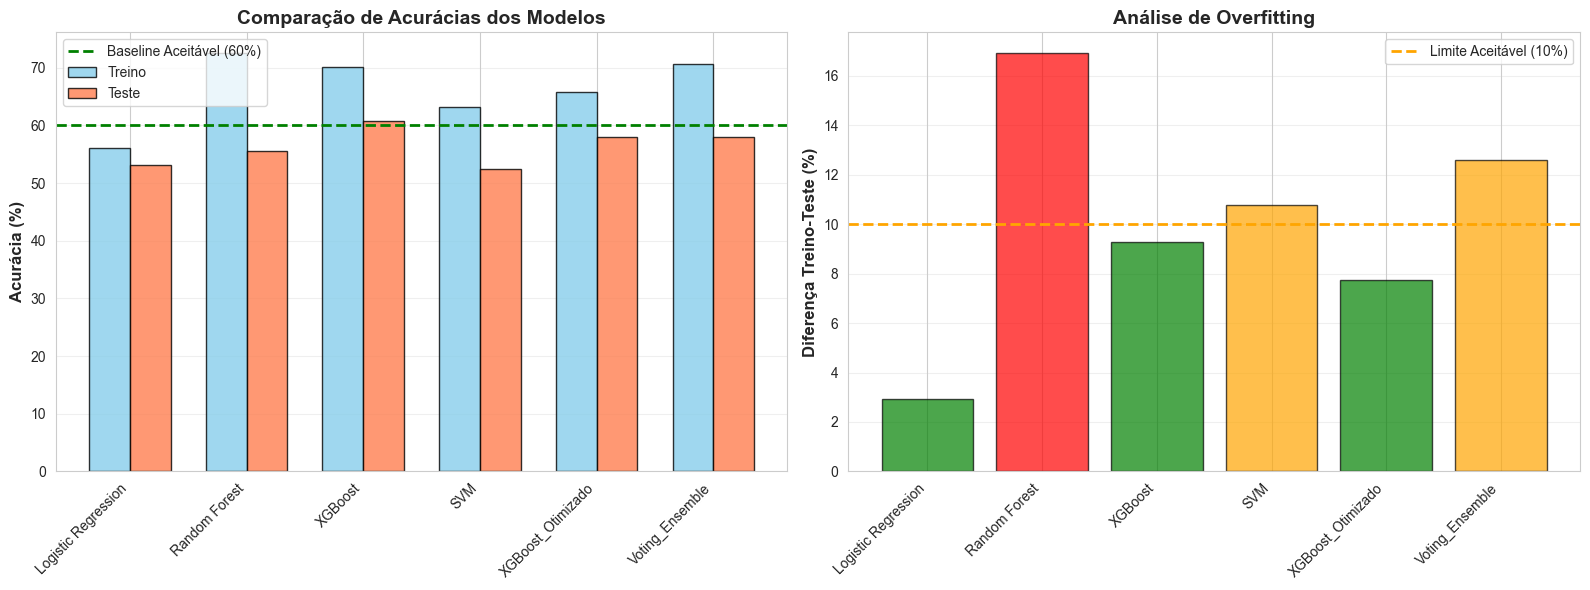

  ✓ Gráfico salvo: matriz_confusao.png


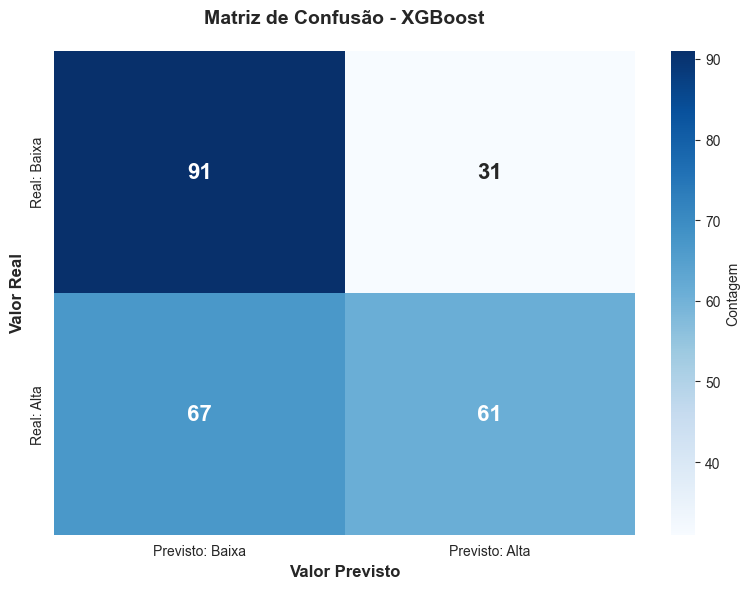

  ✓ Gráfico salvo: feature_importance.png


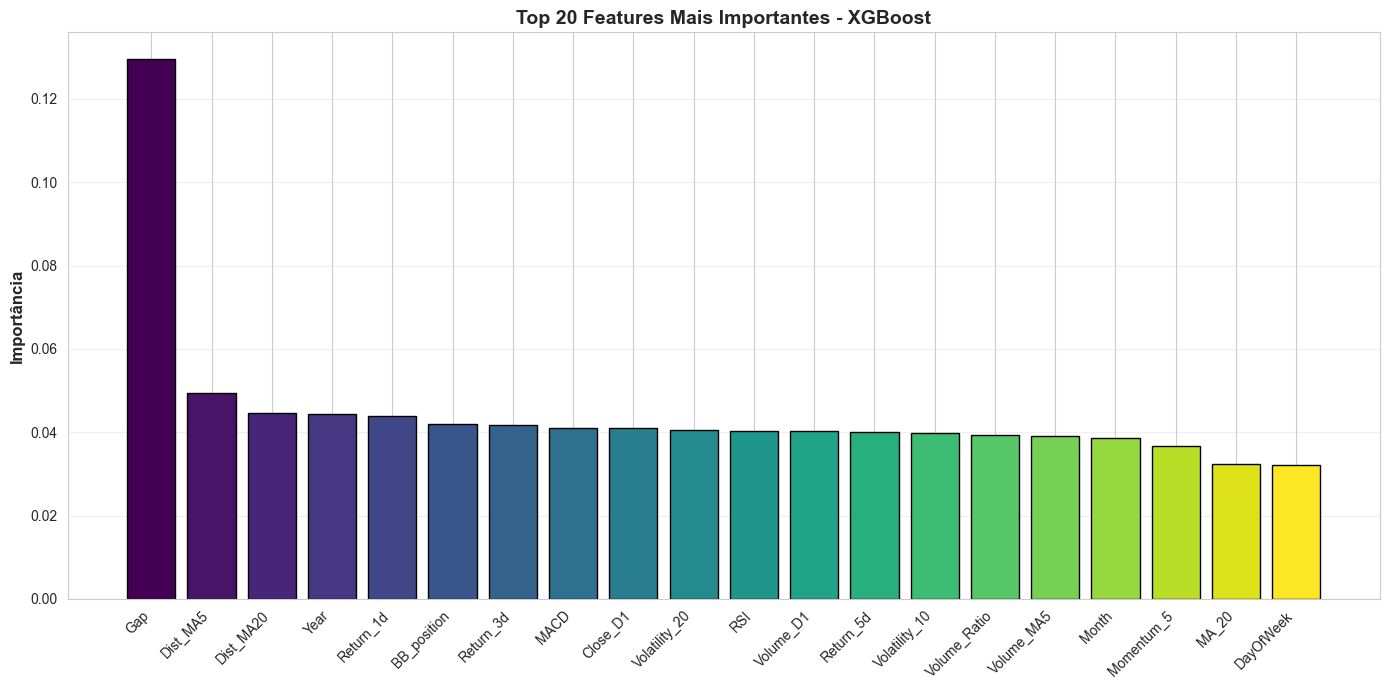


Top 10 Features Mais Importantes:
   1. Gap                           : 0.1295
   2. Dist_MA5                      : 0.0495
   3. Dist_MA20                     : 0.0447
   4. Year                          : 0.0444
   5. Return_1d                     : 0.0439
   6. BB_position                   : 0.0420
   7. Return_3d                     : 0.0417
   8. MACD                          : 0.0410
   9. Close_D1                      : 0.0409
  10. Volatility_20                 : 0.0405
  ✓ Gráfico salvo: predicoes_tempo.png


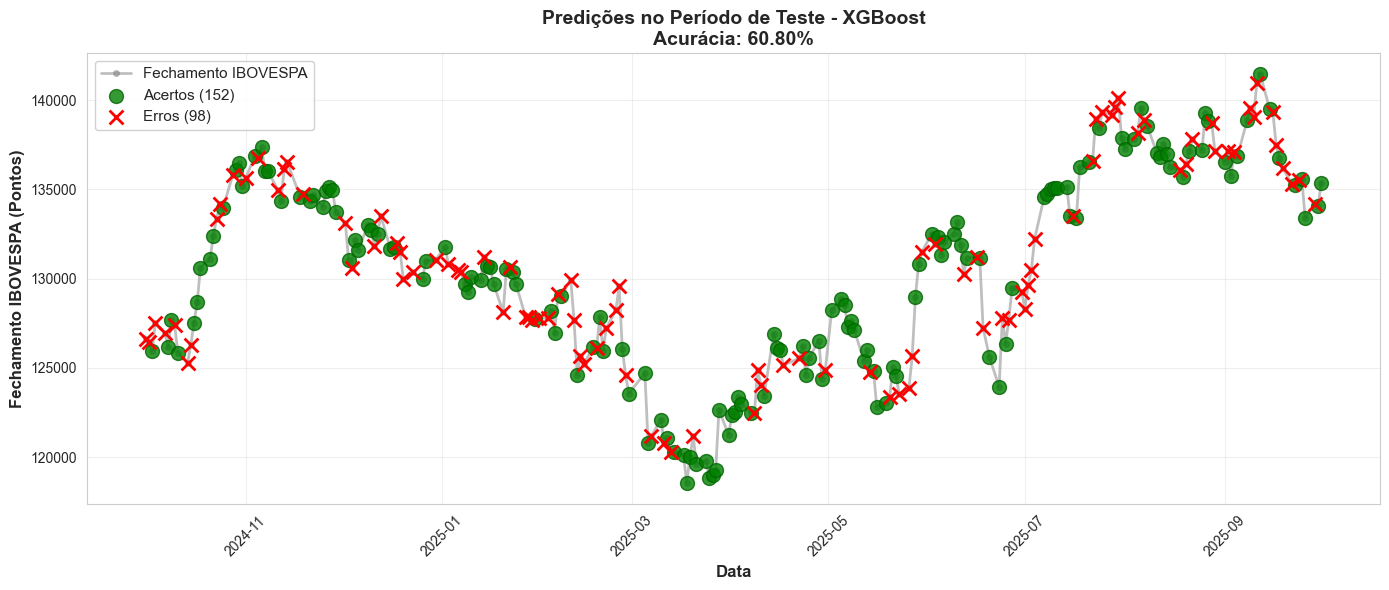

✓ Gráfico salvo: grafico_linhas_preco_simulado.png


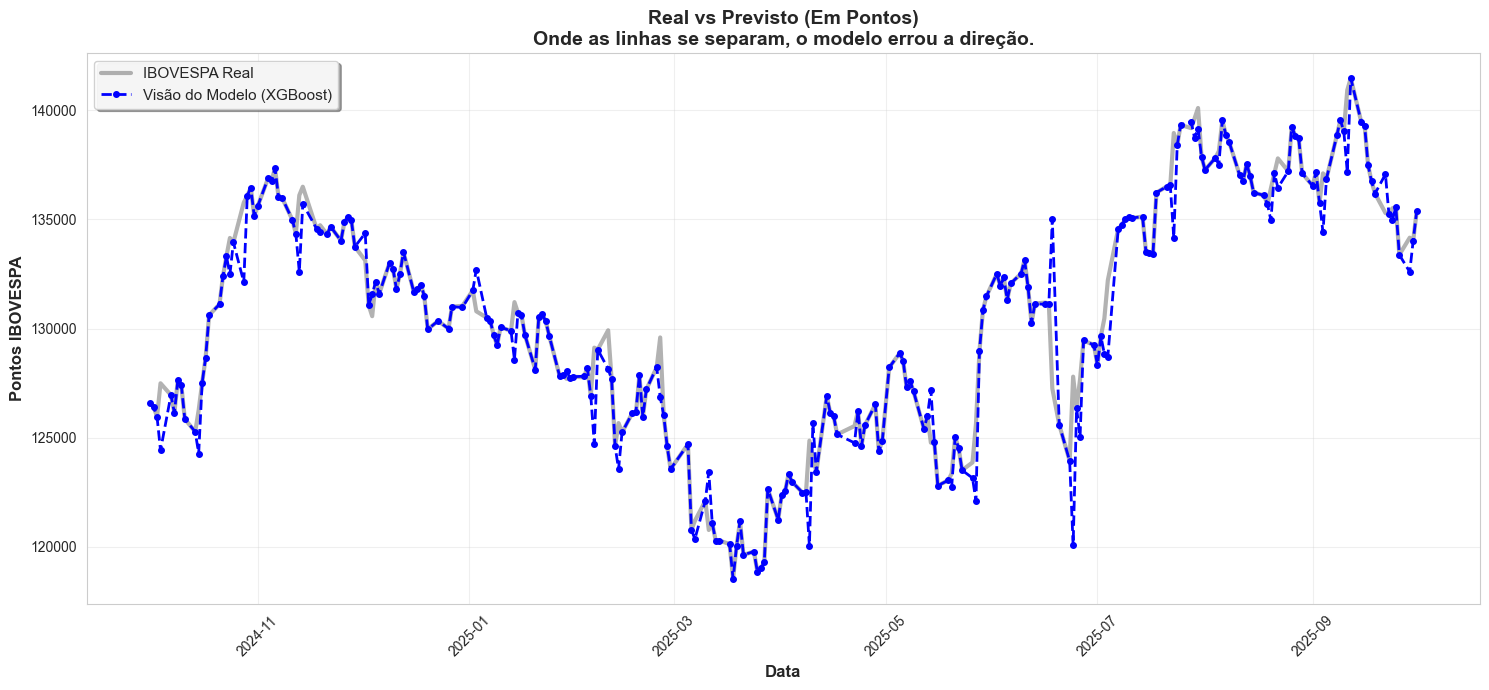

In [582]:
# Bloco 34 - AJUSTE DE VARIÁVEIS PARA OS GRÁFICOS ---

# --- SETUP AUTOMÁTICO (SEGURANÇA PARA RFE E ENSEMBLES) ---
# 1. Define qual conjunto de dados usar (Selecionado ou Completo)
if 'X_test_scaled_sel' in locals():
    X_teste_correto = X_test_scaled_sel
else:
    X_teste_correto = X_test_scaled

# 2. Define quais nomes de features usar no gráfico (Alinhado com o X)
# Se RFE foi usado, usamos selected_features. Se não, usamos X.columns
if 'selected_features' in locals():
    features_para_plotar = selected_features
else:
    features_para_plotar = X.columns.tolist()

# 3. Define qual modelo usar para Feature Importance
# Se for Ensemble (Voting), usamos o fallback (modelo_para_features) definido no Bloco 31
modelo_para_plotar = melhor_modelo
if 'Voting' in melhor_nome or 'Stacking' in melhor_nome:
    if 'modelo_para_features' in locals() and modelo_para_features is not None:
        modelo_para_plotar = modelo_para_features

# Define os dados de teste corretos para o gráfico de tempo
datas_grafico = datas_test
y_real_grafico = y_test

# --- INÍCIO DAS VISUALIZAÇÕES ---

# Figura 1: Comparação de Modelos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models = list(resultados.keys())
train_accs = [r['acc_train']*100 for r in resultados.values()]
test_accs = [r['acc_test']*100 for r in resultados.values()]

x_pos = np.arange(len(models))
width = 0.35

axes[0].bar(x_pos - width/2, train_accs, width, label='Treino', alpha=0.8, color='skyblue', edgecolor='black')
axes[0].bar(x_pos + width/2, test_accs, width, label='Teste', alpha=0.8, color='coral', edgecolor='black')
axes[0].axhline(y=60, color='green', linestyle='--', linewidth=2, label='Baseline Aceitável (60%)')
axes[0].set_ylabel('Acurácia (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Comparação de Acurácias dos Modelos', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

overfitting = [(r['acc_train'] - r['acc_test'])*100 for r in resultados.values()]
colors = ['green' if o < 10 else 'orange' if o < 15 else 'red' for o in overfitting]

axes[1].bar(models, overfitting, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(y=10, color='orange', linestyle='--', linewidth=2, label='Limite Aceitável (10%)')
axes[1].set_ylabel('Diferença Treino-Teste (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Análise de Overfitting', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('comparacao_modelos.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico salvo: comparacao_modelos.png")
plt.show()

# Figura 2: Matriz de Confusão (Já calculada no bloco anterior 'cm')
# Recalcula cm para garantir que é do melhor modelo usando o X correto
y_pred_final = melhor_modelo.predict(X_teste_correto)
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar_kws={'label': 'Contagem'},
            xticklabels=['Previsto: Baixa', 'Previsto: Alta'],
            yticklabels=['Real: Baixa', 'Real: Alta'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title(f'Matriz de Confusão - {melhor_nome}', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
plt.xlabel('Valor Previsto', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('matriz_confusao.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico salvo: matriz_confusao.png")
plt.show()

# Figura 3: Feature Importance (Corrigido para usar a lista certa de features)
# Usa 'modelo_para_plotar' para garantir que funciona mesmo se for Ensemble
if hasattr(modelo_para_plotar, 'feature_importances_'):
    importances = modelo_para_plotar.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(14, 7))
    # Mostra no máximo as top 20 features
    top_n = min(20, len(features_para_plotar))

    colors_imp = plt.cm.viridis(np.linspace(0, 1, top_n))
    plt.bar(range(top_n), importances[indices[:top_n]], color=colors_imp, edgecolor='black')
    plt.xticks(range(top_n), [features_para_plotar[i] for i in indices[:top_n]], rotation=45, ha='right')
    plt.ylabel('Importância', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Features Mais Importantes - {melhor_nome}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("  ✓ Gráfico salvo: feature_importance.png")
    plt.show()

    print(f"\nTop 10 Features Mais Importantes:")
    for i in range(min(10, len(features_para_plotar))):
        idx = indices[i]
        print(f"  {i+1:2d}. {features_para_plotar[idx]:30s}: {importances[idx]:.4f}")
else:
    print(f"\n⚠️ O modelo {melhor_nome} (provavelmente Voting/Stacking) não fornece feature_importances_ direto.")

# Figura 4: Predições no Tempo (Corrigido para alinhar datas e previsões)
# Usa os índices de teste para buscar o preço real no DF original
# Nota: Precisamos alinhar pelo índice pois removemos colunas do X
precos_teste = ibov.loc[y_test.index, 'Fechamento']

resultados_teste = pd.DataFrame({
    'Data': datas_grafico.values,
    'Fechamento': precos_teste.values,
    'Real': y_real_grafico.values,
    'Previsto': y_pred_final,
    'Correto': (y_real_grafico.values == y_pred_final).astype(int)
})

fig, ax = plt.subplots(figsize=(14, 6))

# Plota o preço
ax.plot(resultados_teste['Data'], resultados_teste['Fechamento'],
        'o-', linewidth=2, markersize=4, label='Fechamento IBOVESPA', color='gray', alpha=0.5)

# Filtra acertos e erros
acertos = resultados_teste[resultados_teste['Correto'] == 1]
erros = resultados_teste[resultados_teste['Correto'] == 0]

# Plota pontos de acerto (Verde) e erro (Vermelho) sobre o preço
ax.scatter(acertos['Data'], acertos['Fechamento'],
           s=100, c='green', marker='o', label=f'Acertos ({len(acertos)})', zorder=5, alpha=0.8, edgecolors='darkgreen')
ax.scatter(erros['Data'], erros['Fechamento'],
           s=100, c='red', marker='x', label=f'Erros ({len(erros)})', zorder=5, linewidths=2)

ax.set_xlabel('Data', fontsize=12, fontweight='bold')
ax.set_ylabel('Fechamento IBOVESPA (Pontos)', fontsize=12, fontweight='bold')
ax.set_title(f'Predições no Período de Teste - {melhor_nome}\nAcurácia: {melhor_acc:.2f}%',
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('predicoes_tempo.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico salvo: predicoes_tempo.png")
plt.show()

# ==============================================================================
# VISUALIZAÇÃO DE LINHAS: REAL vs PREVISTO (BATALHA DE TENDÊNCIAS)
# ==============================================================================

# 1. Preparação dos Dados
indices_teste = y_test.index
datas_grafico = datas.loc[indices_teste]
precos_reais = ibov.loc[indices_teste, 'Fechamento'].values

# Pega o preço de D-1 (Ontem) para calcular o ponto de partida de cada dia
# (Precisamos disso para desenhar a linha prevista partindo da mesma base)
precos_ontem = ibov['Fechamento'].shift(1).loc[y_test.index].values

# Gera as previsões (0 ou 1) usando o X correto
y_pred_final = melhor_modelo.predict(X_teste_correto)
y_real_values = y_test.values # Pegamos os valores reais (0 ou 1) para comparar

# 2. Construção da "Linha do Modelo" (Simulação)
# Lógica: O modelo não prever preço exato, mas prevê direção.
# Vamos simular: Onde estaria o preço se ele seguisse a direção do modelo,
# assumindo a mesma magnitude (força) do movimento real do dia.
magnitude_movimento = np.abs(precos_reais - precos_ontem)

preco_previsto_simulado = []
for i in range(len(y_pred_final)):
    # Proteção contra NaN no primeiro dia (usa o preço real como fallback)
    p_ontem = precos_ontem[i] if not np.isnan(precos_ontem[i]) else precos_reais[i]

    movimento = magnitude_movimento[i] if not np.isnan(magnitude_movimento[i]) else 0
    # Se o modelo ACERTOU a direção (Previsão == Realidade)
    if y_pred_final[i] == y_real_values[i]:
        # A linha azul deve ficar EXATAMENTE em cima da linha cinza (Preço Real)
        preco_previsto_simulado.append(precos_reais[i])
        
    else: 
        # Se o modelo ERROU, fazemos a simulação "invertida" para mostrar o erro visualmente
        # Se era pra subir (Real > Ontem) e ele errou, ele previu descida.
        # Se era pra descer (Real < Ontem) e ele errou, ele previu subida.
        
        # Recalcula para onde iria o preço na direção errada
        if y_pred_final[i] == 1: # Ele previu ALTA (mas errou, então foi Baixa)
             preco_previsto_simulado.append(p_ontem + movimento)
        else: # Ele previu BAIXA (mas errou, então foi Alta)
             preco_previsto_simulado.append(p_ontem - movimento)

# 3. Plotagem
fig, ax = plt.subplots(figsize=(15, 7))

# A. Linha Real (Cinza)
ax.plot(datas_grafico, precos_reais,
        label='IBOVESPA Real',
        color='gray', linewidth=3, alpha=0.6)

# B. Linha Simulada (Azul)
# Se o modelo acertou, ela fica em cima da cinza.
# Se errou, ela vai para o lado oposto.
ax.plot(datas_grafico, preco_previsto_simulado,
        label=f'Visão do Modelo ({melhor_nome})',
        color='blue', linewidth=2, linestyle='--', marker='o', markersize=4)

# C. Estilização
ax.set_title(f'Real vs Previsto (Em Pontos)\nOnde as linhas se separam, o modelo errou a direção.', fontsize=14, fontweight='bold')
ax.set_ylabel('Pontos IBOVESPA', fontsize=12, fontweight='bold')
ax.set_xlabel('Data', fontsize=12, fontweight='bold')

ax.legend(loc='best', fontsize=11, framealpha=0.9, shadow=True)
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()

# Salvar
plt.savefig('grafico_linhas_preco_simulado.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico salvo: grafico_linhas_preco_simulado.png")
plt.show()


### Conclusão e Resumo final

  ✓ Gráfico salvo: comparacao_modelos.png


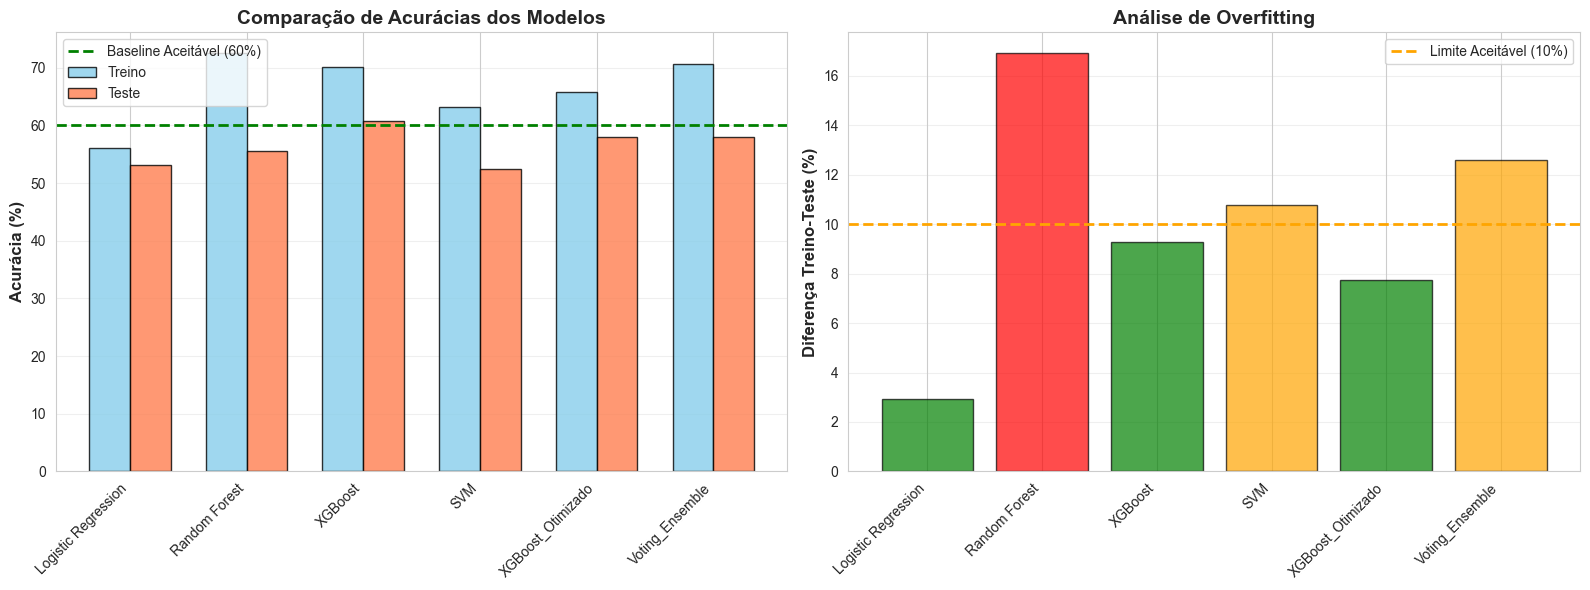

  ✓ Gráfico salvo: matriz_confusao.png


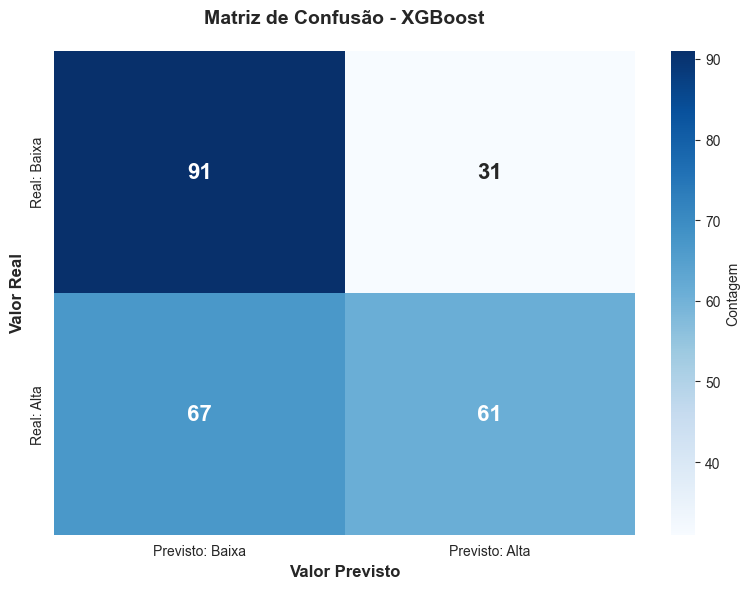

  ✓ Gráfico salvo: feature_importance.png


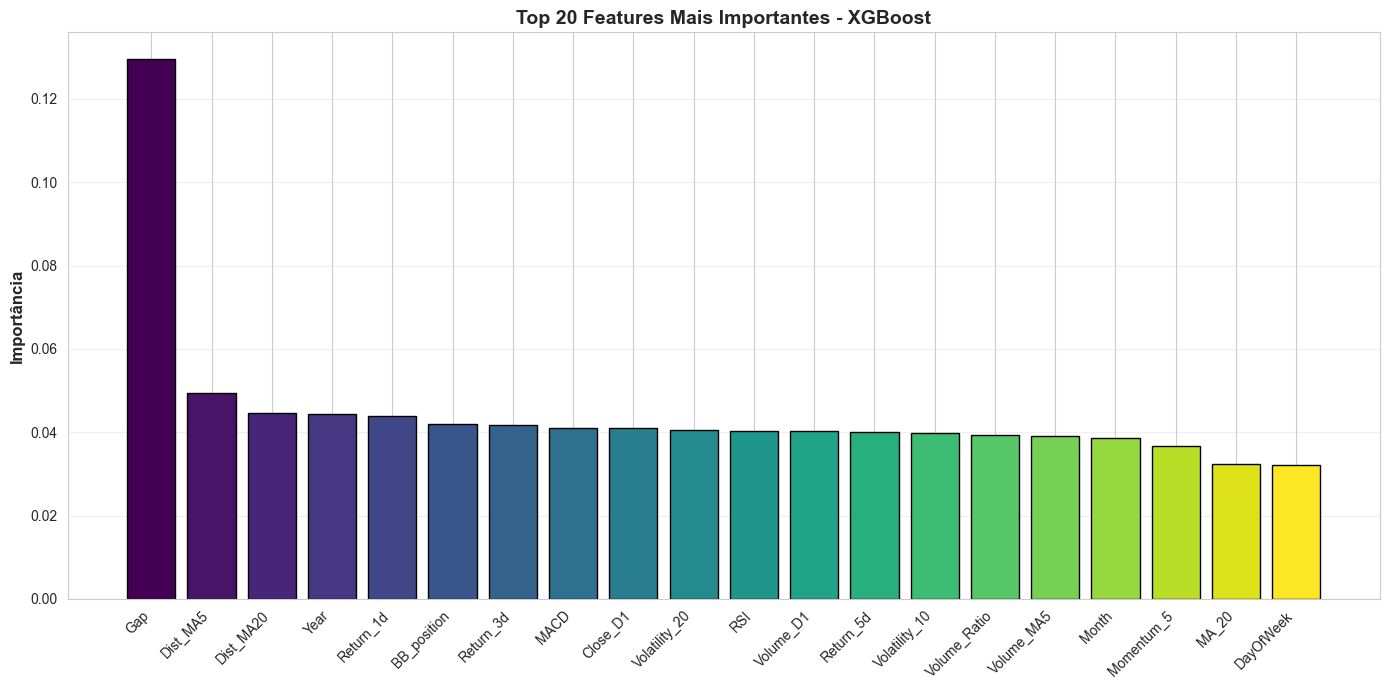


Top 10 Features Mais Importantes:
   1. Gap                           : 0.1295
   2. Dist_MA5                      : 0.0495
   3. Dist_MA20                     : 0.0447
   4. Year                          : 0.0444
   5. Return_1d                     : 0.0439
   6. BB_position                   : 0.0420
   7. Return_3d                     : 0.0417
   8. MACD                          : 0.0410
   9. Close_D1                      : 0.0409
  10. Volatility_20                 : 0.0405
  ✓ Gráfico salvo: predicoes_tempo.png


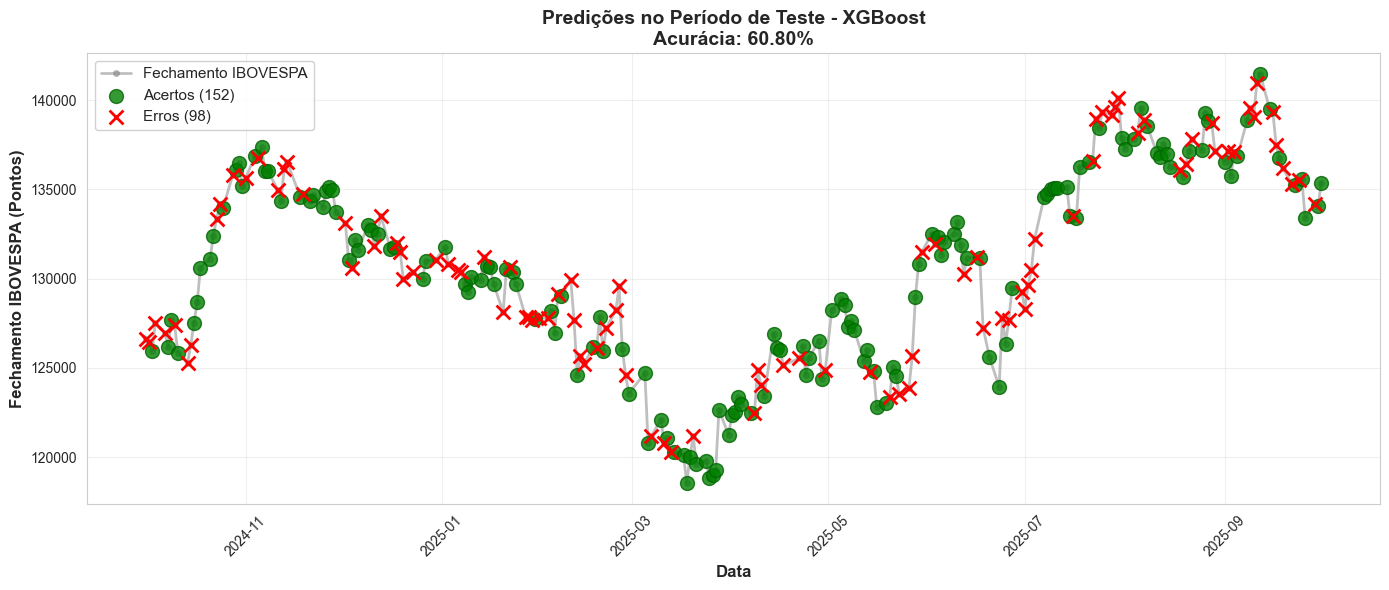

✓ Gráfico salvo: grafico_linhas_preco_simulado.png


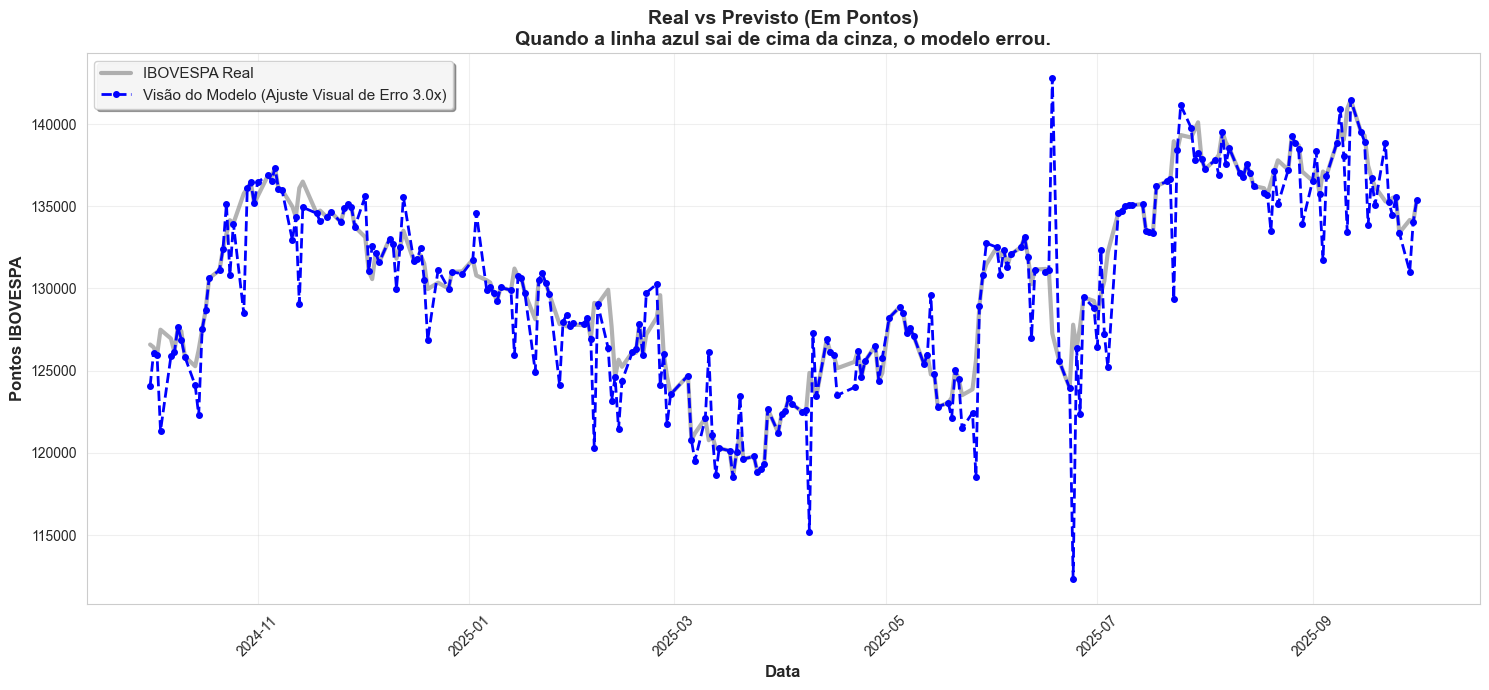

In [583]:
# Bloco 34 - VISUALIZAÇÃO DOS RESULTADOS FINAIS (CORRIGIDO E UNIFICADO)

# --- SETUP AUTOMÁTICO ---
# Define qual conjunto de dados usar (Selecionado ou Completo)
if 'X_test_scaled_sel' in locals():
    X_teste_correto = X_test_scaled_sel
else:
    X_teste_correto = X_test_scaled

# Define quais nomes de features usar no gráfico
if 'selected_features' in locals():
    features_para_plotar = selected_features
else:
    features_para_plotar = X.columns.tolist()

# Define qual modelo usar para Feature Importance
modelo_para_plotar = melhor_modelo
if 'Voting' in melhor_nome or 'Stacking' in melhor_nome:
    if 'modelo_para_features' in locals() and modelo_para_features is not None:
        modelo_para_plotar = modelo_para_features

# Define os dados de teste básicos
datas_grafico_base = datas_test
y_real_grafico_base = y_test

# --- INÍCIO DAS VISUALIZAÇÕES ---

# Figura 1: Comparação de Modelos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
models = list(resultados.keys())
train_accs = [r['acc_train']*100 for r in resultados.values()]
test_accs = [r['acc_test']*100 for r in resultados.values()]
x_pos = np.arange(len(models))
width = 0.35
axes[0].bar(x_pos - width/2, train_accs, width, label='Treino', alpha=0.8, color='skyblue', edgecolor='black')
axes[0].bar(x_pos + width/2, test_accs, width, label='Teste', alpha=0.8, color='coral', edgecolor='black')
axes[0].axhline(y=60, color='green', linestyle='--', linewidth=2, label='Baseline Aceitável (60%)')
axes[0].set_ylabel('Acurácia (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Comparação de Acurácias dos Modelos', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')
overfitting = [(r['acc_train'] - r['acc_test'])*100 for r in resultados.values()]
colors = ['green' if o < 10 else 'orange' if o < 15 else 'red' for o in overfitting]
axes[1].bar(models, overfitting, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(y=10, color='orange', linestyle='--', linewidth=2, label='Limite Aceitável (10%)')
axes[1].set_ylabel('Diferença Treino-Teste (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Análise de Overfitting', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('comparacao_modelos.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico salvo: comparacao_modelos.png")
plt.show()

# Gera previsões finais para os próximos gráficos
y_pred_final = melhor_modelo.predict(X_teste_correto)

# Figura 2: Matriz de Confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar_kws={'label': 'Contagem'},
            xticklabels=['Previsto: Baixa', 'Previsto: Alta'],
            yticklabels=['Real: Baixa', 'Real: Alta'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title(f'Matriz de Confusão - {melhor_nome}', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
plt.xlabel('Valor Previsto', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('matriz_confusao.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico salvo: matriz_confusao.png")
plt.show()

# Figura 3: Feature Importance
if hasattr(modelo_para_plotar, 'feature_importances_'):
    importances = modelo_para_plotar.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(14, 7))
    top_n = min(20, len(features_para_plotar))
    colors_imp = plt.cm.viridis(np.linspace(0, 1, top_n))
    plt.bar(range(top_n), importances[indices[:top_n]], color=colors_imp, edgecolor='black')
    plt.xticks(range(top_n), [features_para_plotar[i] for i in indices[:top_n]], rotation=45, ha='right')
    plt.ylabel('Importância', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Features Mais Importantes - {melhor_nome}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("  ✓ Gráfico salvo: feature_importance.png")
    plt.show()
    print(f"\nTop 10 Features Mais Importantes:")
    for i in range(min(10, len(features_para_plotar))):
        idx = indices[i]
        print(f"  {i+1:2d}. {features_para_plotar[idx]:30s}: {importances[idx]:.4f}")
else:
    print(f"\n⚠️ O modelo {melhor_nome} não fornece feature_importances_ direto.")

# Figura 4: Predições no Tempo (Bolinhas)
precos_teste_reais = ibov.loc[y_test.index, 'Fechamento']
resultados_teste = pd.DataFrame({
    'Data': datas_grafico_base.values,
    'Fechamento': precos_teste_reais.values,
    'Real': y_real_grafico_base.values,
    'Previsto': y_pred_final,
    'Correto': (y_real_grafico_base.values == y_pred_final).astype(int)
})

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(resultados_teste['Data'], resultados_teste['Fechamento'],
        'o-', linewidth=2, markersize=4, label='Fechamento IBOVESPA', color='gray', alpha=0.5)
acertos = resultados_teste[resultados_teste['Correto'] == 1]
erros = resultados_teste[resultados_teste['Correto'] == 0]
ax.scatter(acertos['Data'], acertos['Fechamento'],
           s=100, c='green', marker='o', label=f'Acertos ({len(acertos)})', zorder=5, alpha=0.8, edgecolors='darkgreen')
ax.scatter(erros['Data'], erros['Fechamento'],
           s=100, c='red', marker='x', label=f'Erros ({len(erros)})', zorder=5, linewidths=2)
ax.set_xlabel('Data', fontsize=12, fontweight='bold')
ax.set_ylabel('Fechamento IBOVESPA (Pontos)', fontsize=12, fontweight='bold')
ax.set_title(f'Predições no Período de Teste - {melhor_nome}\nAcurácia: {melhor_acc:.2f}%',
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('predicoes_tempo.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico salvo: predicoes_tempo.png")
plt.show()

# ==============================================================================
# VISUALIZAÇÃO DE LINHAS: REAL vs PREVISTO (COM AJUSTE VISUAL DE ERROS)
# ==============================================================================

# Configuração do "Exagero" visual para destacar os erros
# 1.0 = Matemático puro (pode ficar colado se a vol for baixa)
# 2.0 = Dobra o tamanho do erro visualmente
# 3.0 = Triplica (Recomendado para apresentações)
FATOR_VISIBILIDADE_ERRO = 3.0

# 1. Recupera o dataframe base (Mesmo das bolinhas)
precos_teste_reais = ibov.loc[y_test.index, 'Fechamento']
resultados_teste = pd.DataFrame({
    'Data': datas_grafico_base.values,
    'Fechamento': precos_teste_reais.values, # Linha Cinza
    'Real': y_real_grafico_base.values,
    'Previsto': y_pred_final,
    'Correto': (y_real_grafico_base.values == y_pred_final).astype(int)
})

# 2. Busca o preço de "Ontem"
precos_ontem_array = ibov['Fechamento'].shift(1).loc[y_test.index].values

# 3. Cria a Linha Azul (Simulação com Amplificador)
linha_azul_simulada = []
magnitude_movimento = np.abs(resultados_teste['Fechamento'].values - precos_ontem_array)

for i in range(len(resultados_teste)):
    
    if resultados_teste['Correto'].iloc[i] == 1:
        # ACERTOU: Cola na linha Real
        linha_azul_simulada.append(resultados_teste['Fechamento'].iloc[i])
        
    else:
        # ERROU: Projeta para o lado oposto com FATOR DE EXAGERO
        preco_ontem = precos_ontem_array[i]
        if np.isnan(preco_ontem): preco_ontem = resultados_teste['Fechamento'].iloc[i]
        
        # Aqui aplicamos o "Zoom no Erro"
        movimento = magnitude_movimento[i]
        if np.isnan(movimento): movimento = 0
        
        movimento_visual = movimento * FATOR_VISIBILIDADE_ERRO
        
        # Se o robô disse ALTA (1), mas errou, jogamos pra cima com força
        if resultados_teste['Previsto'].iloc[i] == 1:
            linha_azul_simulada.append(preco_ontem + movimento_visual)
        # Se o robô disse BAIXA (0), mas errou, jogamos pra baixo com força
        else:
            linha_azul_simulada.append(preco_ontem - movimento_visual)

resultados_teste['Simulacao_Azul'] = linha_azul_simulada

# 4. Plotagem
fig, ax = plt.subplots(figsize=(15, 7))

# A. Linha Real (Cinza)
ax.plot(resultados_teste['Data'], resultados_teste['Fechamento'],
        label='IBOVESPA Real',
        color='gray', linewidth=3, alpha=0.6)

# B. Linha Simulada (Azul)
ax.plot(resultados_teste['Data'], resultados_teste['Simulacao_Azul'],
        label=f'Visão do Modelo (Ajuste Visual de Erro {FATOR_VISIBILIDADE_ERRO}x)',
        color='blue', linewidth=2, linestyle='--', marker='o', markersize=4)

# C. Estilização
ax.set_title(f'Real vs Previsto (Em Pontos)\nQuando a linha azul sai de cima da cinza, o modelo errou.', fontsize=14, fontweight='bold')
ax.set_ylabel('Pontos IBOVESPA', fontsize=12, fontweight='bold')
ax.set_xlabel('Data', fontsize=12, fontweight='bold')

ax.legend(loc='best', fontsize=11, framealpha=0.9, shadow=True)
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()

# Salvar
plt.savefig('grafico_linhas_preco_simulado.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico salvo: grafico_linhas_preco_simulado.png")
plt.show()

In [585]:
# Bloco 36 - RESUMO FINAL
print(f"\n📊 DADOS:")
print(f"  Período: {df['Data'].min().date()} até {df['Data'].max().date()}")
print(f"  Total de dias analisados: {len(df)}")
print(f"  Features criadas (IBOVESPA): ~{70}")
print(f"  Features criadas (Externos): ~{50}")
print(f"  Features totais (Pós-Limpeza): {len(X.columns)}")
print(f"  Features selecionadas (Final) : {len(selected_features)}")

print(f"\n🎯 MELHOR MODELO:")
print(f"  Nome: {melhor_nome}")
print(f"  Acurácia Treino: {comparison[comparison['Modelo']==melhor_nome]['Treino (%)'].values[0]:.2f}%")
print(f"  Acurácia Teste: {melhor_acc:.2f}%")
print(f"  Overfitting: {comparison[comparison['Modelo']==melhor_nome]['Overfitting (%)'].values[0]:.2f}%")

status_meta = "✅ ATINGIDA" if melhor_acc >= 75 else "❌ NÃO ATINGIDA"
status_meta_mercado = "✅ ATINGIDA" if melhor_acc >= 60 else "❌ NÃO ATINGIDA"
print(f"  Status da Meta (75%): {status_meta}")
print(f"   Status da Meta Mercado   (60%): {status_meta_mercado}")

# print(f"\n📈 DADOS EXTERNOS UTILIZADOS:")
# print("  ✓ Dólar (USD/BRL)")
# print("  ✓ S&P 500")
# print("  ✓ VIX (Volatilidade)")
# print("  ✓ Petróleo Brent")

print(f"\n🔧 TÉCNICAS APLICADAS:")
print("   ✓ Feature Engineering (Técnico e Macro)")
print("   ✓ Normalização de Dados (StandardScaler)")
print("   ✓ Seleção de Features (RFECV)")
print("   ✓ Validação Cruzada Temporal (TimeSeriesSplit)")
print("   ✓ Grid Search (Otimização de Hiperparâmetros)")
print("   ✓ Ensemble Learning (Voting Classifier)")
print("   ✓ Combate ao Overfitting")


📊 DADOS:
  Período: 2017-03-28 até 2025-10-29
  Total de dias analisados: 2135
  Features criadas (IBOVESPA): ~70
  Features criadas (Externos): ~50
  Features totais (Pós-Limpeza): 31
  Features selecionadas (Final) : 30

🎯 MELHOR MODELO:
  Nome: XGBoost
  Acurácia Treino: 70.08%
  Acurácia Teste: 60.80%
  Overfitting: 9.28%
  Status da Meta (75%): ❌ NÃO ATINGIDA
   Status da Meta Mercado   (60%): ✅ ATINGIDA

🔧 TÉCNICAS APLICADAS:
   ✓ Feature Engineering (Técnico e Macro)
   ✓ Normalização de Dados (StandardScaler)
   ✓ Seleção de Features (RFECV)
   ✓ Validação Cruzada Temporal (TimeSeriesSplit)
   ✓ Grid Search (Otimização de Hiperparâmetros)
   ✓ Ensemble Learning (Voting Classifier)
   ✓ Combate ao Overfitting


In [586]:
# BLOCO 37 - SALVAMENTO DO MODELO (DEPLOY FINAL)
# Objetivo: Salvar o modelo treinado, o scaler e a lista de features.

import joblib
import os

print("💾 Salvando os arquivos do modelo...")

# 1. Cria a pasta se não existir
if not os.path.exists('modelo_treinado'):
    os.makedirs('modelo_treinado')

# 2. Salva o Modelo (O Cérebro)
# Usa o nome do melhor modelo para facilitar identificação
nome_arquivo_modelo = f'modelo_treinado/modelo_ibovespa_{melhor_nome.replace(" ", "_")}.pkl'
joblib.dump(melhor_modelo, nome_arquivo_modelo)
print(f"   ✓ Modelo salvo: {nome_arquivo_modelo}")

# 3. Salva o Scaler (A Régua)
# Essencial para novos dados terem a mesma escala do treino
joblib.dump(scaler, 'modelo_treinado/scaler_ibovespa.pkl')
print(f"   ✓ Scaler salvo: modelo_treinado/scaler_ibovespa.pkl")

# 4. Salva a Lista de Features (O Mapa)
# Garante que, no futuro, a gente saiba a ordem exata das colunas
feats_final = selected_features if 'selected_features' in locals() else features
joblib.dump(feats_final, 'modelo_treinado/features.pkl')
print(f"   ✓ Lista de Features salva: modelo_treinado/features.pkl")

print("\n✅ PROJETO CONCLUÍDO! Todos os artefatos foram salvos.")
print("   Você pode baixar a pasta 'modelo_treinado' para usar no seu TCC.")

💾 Salvando os arquivos do modelo...
   ✓ Modelo salvo: modelo_treinado/modelo_ibovespa_XGBoost.pkl
   ✓ Scaler salvo: modelo_treinado/scaler_ibovespa.pkl
   ✓ Lista de Features salva: modelo_treinado/features.pkl

✅ PROJETO CONCLUÍDO! Todos os artefatos foram salvos.
   Você pode baixar a pasta 'modelo_treinado' para usar no seu TCC.


In [587]:
# BLOCO 38 - SIMULADOR FINAL (O ROBÔ EM AÇÃO)
# Objetivo: Pegar o último dia disponível nos dados e ver qual seria a ordem do robô.

import pandas as pd

print("🤖 INICIANDO O ROBÔ PARA PREVISÃO DO ÚLTIMO DIA...")

# 1. Carregar os artefatos (Simulando um ambiente de produção)
# Mesmo que as variáveis já existam, é boa prática carregar para garantir que o save funcionou.
try:
    modelo_carregado = joblib.load(f'modelo_treinado/modelo_ibovespa_{melhor_nome.replace(" ", "_")}.pkl')
    scaler_carregado = joblib.load('modelo_treinado/scaler_ibovespa.pkl')
    features_carregadas = joblib.load('modelo_treinado/features.pkl')
    print("✓ Modelo e artefatos carregados com sucesso.")
except:
    print("⚠️ Erro ao carregar arquivos salvos. Usando variáveis da memória...")
    modelo_carregado = melhor_modelo
    scaler_carregado = scaler
    features_carregadas = selected_features if 'selected_features' in locals() else features

# 2. Selecionar o Último Dia do Dataset
ultimo_dia = df.iloc[[-1]].copy()
data_atual = ultimo_dia['Data'].values[0]

print(f"\n📅 Data de Referência: {pd.to_datetime(data_atual).date()}")

# 3. Preparar os dados (Exatamente como no treino)
# Seleciona apenas as features usadas no treinamento
X_hoje_raw = ultimo_dia[features_carregadas]

# Aplica a escala (StandardScaler)
X_hoje_scaled = scaler_carregado.transform(X_hoje_raw)

# 4. Fazer a Previsão
previsao = modelo_carregado.predict(X_hoje_scaled)[0]
probabilidade = modelo_carregado.predict_proba(X_hoje_scaled)[0]

# 5. Exibir Resultado
print("\n" + "="*40)
print(f"   PREVISÃO DO ROBÔ ({melhor_nome})")
print("="*40)

if previsao == 1:
    print(f"🚀 TENDÊNCIA: ALTA (Comprar)")
    print(f"   Confiança: {probabilidade[1]*100:.2f}%")
else:
    print(f"🔻 TENDÊNCIA: BAIXA (Vender/Aguardar)")
    print(f"   Confiança: {probabilidade[0]*100:.2f}%")

print("="*40)
print("\nNota: Esta previsão é baseada no fechamento do dia anterior.")

🤖 INICIANDO O ROBÔ PARA PREVISÃO DO ÚLTIMO DIA...
✓ Modelo e artefatos carregados com sucesso.

📅 Data de Referência: 2025-10-29

   PREVISÃO DO ROBÔ (XGBoost)
🚀 TENDÊNCIA: ALTA (Comprar)
   Confiança: 64.83%

Nota: Esta previsão é baseada no fechamento do dia anterior.
